# Import

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')



In [1]:
import pandas as pd
import random
import os
import numpy as np
# !pip install catboost
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import catboost
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
# !pip install filterpy
import math
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

import itertools
import math


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(1422) # Seed 고정

In [3]:
base= ''

train_df = pd.read_csv(base+'train.csv')

In [4]:
train_x = train_df.filter(regex='X') # Input : X Featrue
train_y = train_df.filter(regex='Y') # Output : Y Feature

In [6]:

train_x

,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09,X_10,...,X_47,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56
0,70.544,103.320,67.47,1,101.892,74.983,29.45,62.38,245.71,0.0,...,1,1,9706.03,137.043591,135.359219,147.837968,134.313475,125.605427,136.721425,125.028256
1,69.524,103.321,65.17,1,101.944,72.943,28.73,61.23,233.61,0.0,...,1,1,10423.43,133.736691,135.979817,149.924692,123.630583,127.893337,143.322659,124.877308
2,72.583,103.320,64.07,1,103.153,72.943,28.81,105.77,272.20,0.0,...,1,1,10948.53,132.805112,131.055355,146.814592,128.939070,127.012195,140.395688,122.238232
3,71.563,103.320,67.57,1,101.971,77.022,28.92,115.21,255.36,0.0,...,1,1,15007.03,134.138760,133.239422,139.720132,132.260824,130.723186,147.624829,134.875225
4,69.524,103.320,63.57,1,101.981,70.904,29.68,103.38,241.46,0.0,...,1,1,11051.03,142.728970,136.620022,134.853555,134.760252,125.647793,139.331105,123.272762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39602,66.465,103.320,62.27,1,103.150,66.825,30.20,77.83,298.05,0.0,...,1,1,60630.73,129.965741,130.807148,133.481737,125.273130,121.780933,133.780110,129.029812
39603,66.465,103.321,62.77,1,102.021,66.825,29.21,102.25,270.67,0.0,...,1,1,60763.43,127.633885,120.158764,142.667802,122.465490,122.987209,143.090741,122.811413
39604,68.504,103.320,64.67,1,103.144,68.864,29.96,102.61,198.07,0.0,...,1,1,8813.33,132.501286,136.893025,134.419328,129.115431,130.920147,140.489232,119.166699
39605,66.465,103.320,63.67,1,102.025,67.845,30.30,112.60,275.52,0.0,...,1,1,62222.33,128.189679,121.495930,141.288011,130.141676,125.518825,136.603634,124.525929


  0%|          | 0/54 [00:00<?, ?it/s]C:\Users\rkd20\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
100%|██████████| 54/54 [00:41<00:00,  1.29it/s]


,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09,X_12,...,kf_X_44,kf_X_45,kf_X_46,kf_X_47,kf_X_48,kf_X_49,kf_X_50,kf_X_51,kf_X_52,kf_X_53
0,70.544,103.320,67.47,1,101.892,74.983,29.45,62.38,245.71,4.34,...,1.002494,1.002494,9681.830424,136.706824,135.026652,147.474282,133.983516,125.297184,136.385461,124.721452
1,69.524,103.321,65.17,1,101.944,72.943,28.73,61.23,233.61,4.38,...,0.995193,0.995193,10463.125216,134.417826,136.614816,150.605471,124.370038,128.465304,143.906278,125.470122
2,72.583,103.320,64.07,1,103.153,72.943,28.81,105.77,272.20,4.36,...,0.996717,0.996717,11008.959730,132.863430,132.432688,148.165211,126.714975,127.943775,142.420532,123.066148
3,71.563,103.320,67.57,1,101.971,77.022,28.92,115.21,255.36,4.33,...,0.997523,0.997523,14001.464930,133.319729,132.551377,142.332612,129.976112,130.279945,146.807645,131.078737
4,69.524,103.320,63.57,1,101.981,70.904,29.68,103.38,241.46,4.35,...,0.998013,0.998013,12899.355654,138.704302,134.670775,136.901889,132.935585,128.206028,143.653289,127.597410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39602,66.465,103.320,62.27,1,103.150,66.825,30.20,77.83,298.05,4.36,...,1.000000,1.000000,56282.257274,129.604506,125.719101,137.318833,124.581296,125.063380,137.602621,128.758425
39603,66.465,103.321,62.77,1,102.021,66.825,29.21,102.25,270.67,4.40,...,1.000000,1.000000,58640.674456,129.265428,124.683345,138.073689,124.194959,124.566170,138.298172,127.727242
39604,68.504,103.320,64.67,1,103.144,68.864,29.96,102.61,198.07,4.38,...,1.000000,1.000000,52616.608456,129.711401,126.340585,137.494041,124.875757,125.353904,138.545457,126.227423
39605,66.465,103.320,63.67,1,102.025,67.845,30.30,112.60,275.52,4.33,...,1.000000,1.000000,55226.707986,129.456898,125.494027,138.027848,125.665171,125.255583,138.178005,125.697982


# Simple EDA

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(20, 5, figsize=(30, 20))
for var, subplot in zip(train_x.columns, ax.flatten()):
    sns.scatterplot(x=var, y=train_y['Y_02'], data=train_x, ax=subplot)

In [ ]:
train_df['is_error'] = "N"
train_df['is_error'][[0, 6, 9, 12, 14, 23, 33, 35, 37, 60, 67, 70, 72, 74, 76, 86, 98, 105, 120, 135, 137, 138, 140, 142, 144, 145, 147, 169, 177, 183, 186, 187, 201, 205, 207, 219, 222, 223, 226, 239, 240, 246, 253, 264, 267, 270, 275, 292, 299, 305, 315, 322, 328, 332, 333, 344, 345, 347, 353, 354, 355, 356, 357, 361, 364, 365, 367, 386, 396, 403, 406, 408, 410, 414, 415, 418, 425, 435, 440, 448, 451, 453, 454, 455, 458, 465, 469, 476, 484, 485, 494, 505, 531, 536, 537, 543, 555, 557, 576, 580, 593, 597, 599, 603, 610, 628, 638, 655, 656, 671, 672, 682, 683, 688, 689, 699, 711, 722, 730, 736, 746, 764, 765, 773, 778, 783, 787, 788, 796, 827, 833, 834, 864, 876, 881, 882, 885, 892, 910, 915, 921, 924, 927, 929, 930, 931, 932, 933, 938, 942, 943, 949, 951, 956, 957, 958, 967, 969, 970, 971, 972, 973, 976, 977, 979, 995, 999, 1020, 1031, 1032, 1043, 1045, 1050, 1053, 1064, 1074, 1078, 1082, 1084, 1091, 1104, 1106, 1107, 1108, 1116, 1123, 1127, 1131, 1140, 1144, 1145, 1153, 1154, 1167, 1189, 1208, 1220, 1232, 1248, 1263, 1267, 1273, 1283, 1286, 1287, 1295, 1311, 1312, 1327, 1328, 1346, 1356, 1358, 1366, 1371, 1372, 1379, 1386, 1390, 1397, 1398, 1421, 1422, 1425, 1426, 1435, 1436, 1453, 1458, 1459, 1462, 1471, 1476, 1479, 1485, 1491, 1500, 1503, 1504, 1505, 1519, 1521, 1545, 1575, 1588, 1603, 1609, 1636, 1637, 1645, 1649, 1657, 1659, 1663, 1683, 1706, 1707, 1725, 1741, 1784, 1819, 1832, 1849, 1854, 1855, 1859, 1872, 1960, 1961, 1963, 1971, 1984, 2007, 2014, 2048, 2068, 2081, 2083, 2085, 2100, 2128, 2145, 2157, 2166, 2170, 2215, 2228, 2231, 2236, 2263, 2307, 2319, 2334, 2361, 2363, 2367, 2374, 2378, 2379, 2382, 2385, 2394, 2395, 2407, 2420, 2430, 2436, 2460, 2465, 2476, 2493, 2500, 2555, 2560, 2578, 2584, 2606, 2618, 2621, 2623, 2625, 2635, 2669, 2675, 2680, 2683, 2685, 2687, 2699, 2705, 2714, 2715, 2717, 2736, 2748, 2754, 2767, 2777, 2791, 2795, 2796, 2797, 2800, 2803, 2806, 2808, 2816, 2827, 2831, 2832, 2833, 2841, 2848, 2858, 2869, 2877, 2880, 2886, 2887, 2895, 2910, 2916, 2918, 2928, 2940, 2947, 2948, 2953, 2959, 2960, 2961, 2964, 2977, 2978, 2980, 2993, 3005, 3013, 3014, 3022, 3026, 3031, 3038, 3055, 3057, 3060, 3070, 3077, 3084, 3087, 3111, 3112, 3121, 3130, 3164, 3172, 3176, 3177, 3178, 3182, 3183, 3193, 3196, 3201, 3217, 3229, 3249, 3251, 3253, 3254, 3262, 3276, 3291, 3299, 3306, 3317, 3341, 3347, 3348, 3356, 3363, 3373, 3374, 3385, 3388, 3391, 3402, 3404, 3415, 3427, 3453, 3454, 3456, 3464, 3492, 3497, 3504, 3523, 3570, 3579, 3607, 3626, 3640, 3643, 3653, 3663, 3702, 3714, 3722, 3724, 3744, 3754, 3768, 3771, 3777, 3778, 3790, 3817, 3839, 3841, 3856, 3859, 3862, 3921, 3934, 3942, 3944, 3947, 3961, 3962, 3965, 3966, 3975, 3979, 3982, 3990, 3994, 4018, 4036, 4058, 4066, 4108, 4109, 4118, 4128, 4144, 4150, 4151, 4153, 4165, 4172, 4207, 4215, 4251, 4258, 4259, 4263, 4264, 4268, 4272, 4301, 4316, 4317, 4321, 4327, 4330, 4357, 4383, 4399, 4405, 4413, 4419, 4438, 4457, 4464, 4467, 4516, 4533, 4535, 4549, 4574, 4580, 4583, 4584, 4603, 4628, 4630, 4636, 4638, 4644, 4659, 4669, 4676, 4680, 4684, 4688, 4696, 4697, 4707, 4715, 4717, 4720, 4728, 4730, 4762, 4769, 4777, 4779, 4791, 4793, 4796, 4805, 4808, 4832, 4834, 4836, 4838, 4846, 4863, 4869, 4877, 4879, 4880, 4882, 4883, 4885, 4893, 4901, 4902, 4914, 4916, 4920, 4925, 4930, 4938, 4950, 4953, 4959, 4960, 4975, 4987, 4990, 4991, 5019, 5034, 5038, 5039, 5040, 5042, 5043, 5044, 5048, 5051, 5053, 5061, 5066, 5075, 5077, 5092, 5099, 5104, 5108, 5119, 5125, 5131, 5133, 5134, 5137, 5138, 5144, 5176, 5185, 5188, 5193, 5195, 5200, 5210, 5212, 5218, 5252, 5256, 5262, 5272, 5286, 5294, 5295, 5296, 5297, 5303, 5306, 5317, 5326, 5331, 5332, 5361, 5364, 5388, 5397, 5398, 5401, 5404, 5406, 5410, 5419, 5420, 5430, 5471, 5476, 5477, 5484, 5494, 5498, 5499, 5508, 5515, 5518, 5532, 5539, 5540, 5541, 5543, 5547, 5576, 5577, 5578, 5598, 5599, 5600, 5601, 5603, 5604, 5606, 5610, 5626, 5628, 5639, 5640, 5642, 5643, 5644, 5645, 5649, 5650, 5651, 5652, 5653, 5655, 5656, 5660, 5661, 5668, 5706, 5708, 5720, 5729, 5773, 5775, 5783, 5787, 5797, 5810, 5812, 5816, 5823, 5829, 5842, 5857, 5890, 5892, 5905, 5933, 5940, 5943, 5949, 5968, 5970, 5979, 6009, 6017, 6028, 6047, 6049, 6050, 6062, 6088, 6103, 6111, 6114, 6141, 6163, 6169, 6173, 6178, 6187, 6206, 6219, 6237, 6239, 6264, 6271, 6276, 6279, 6286, 6309, 6317, 6318, 6341, 6342, 6350, 6353, 6356, 6364, 6367, 6371, 6378, 6387, 6397, 6411, 6422, 6436, 6478, 6486, 6489, 6550, 6559, 6562, 6568, 6576, 6585, 6586, 6622, 6654, 6656, 6657, 6711, 6716, 6727, 6764, 6786, 6790, 6794, 6796, 6806, 6813, 6816, 6847, 6866, 6868, 6871, 6876, 6878, 6934, 6938, 6965, 6983, 6986, 6991, 6993, 6998, 6999, 7026, 7028, 7029, 7031, 7049, 7054, 7089, 7090, 7094, 7095, 7096, 7107, 7109, 7116, 7134, 7137, 7141, 7146, 7150, 7161, 7186, 7188, 7195, 7202, 7207, 7208, 7210, 7211, 7233, 7247, 7255, 7258, 7262, 7264, 7271, 7279, 7287, 7289, 7299, 7325, 7331, 7336, 7353, 7355, 7358, 7359, 7370, 7379, 7402, 7403, 7405, 7411, 7413, 7435, 7436, 7440, 7441, 7442, 7443, 7444, 7446, 7447, 7451, 7455, 7457, 7465, 7466, 7473, 7475, 7482, 7494, 7497, 7501, 7505, 7507, 7511, 7517, 7528, 7541, 7558, 7582, 7583, 7587, 7612, 7620, 7625, 7629, 7631, 7657, 7660, 7665, 7690, 7733, 7737, 7741, 7743, 7746, 7749, 7762, 7768, 7772, 7773, 7780, 7793, 7797, 7812, 7825, 7831, 7833, 7835, 7843, 7844, 7845, 7846, 7853, 7856, 7859, 7894, 7895, 7903, 7905, 7907, 7909, 7910, 7912, 7914, 7917, 7920, 7925, 7926, 7943, 7945, 7946, 7955, 7961, 7965, 7968, 7980, 7981, 7983, 7987, 7997, 7999, 8010, 8012, 8019, 8030, 8037, 8050, 8055, 8060, 8064, 8069, 8085, 8090, 8103, 8109, 8112, 8127, 8170, 8183, 8216, 8217, 8231, 8242, 8251, 8276, 8298, 8302, 8304, 8318, 8328, 8329, 8353, 8361, 8370, 8390, 8393, 8401, 8405, 8408, 8411, 8439, 8445, 8452, 8454, 8458, 8466, 8468, 8469, 8483, 8489, 8498, 8499, 8512, 8523, 8525, 8554, 8562, 8565, 8587, 8588, 8599, 8600, 8602, 8608, 8615, 8621, 8636, 8658, 8674, 8691, 8707, 8715, 8733, 8736, 8739, 8758, 8761, 8774, 8788, 8792, 8794, 8796, 8811, 8823, 8830, 8838, 8928, 8945, 8947, 8952, 8969, 8984, 9029, 9052, 9095, 9097, 9145, 9147, 9151, 9163, 9170, 9200, 9214, 9218, 9229, 9247, 9250, 9259, 9291, 9297, 9302, 9303, 9317, 9318, 9323, 9324, 9327, 9330, 9336, 9363, 9369, 9374, 9389, 9390, 9394, 9395, 9416, 9431, 9448, 9450, 9471, 9485, 9488, 9494, 9502, 9503, 9504, 9507, 9526, 9529, 9545, 9553, 9591, 9625, 9627, 9640, 9644, 9645, 9648, 9653, 9654, 9655, 9658, 9659, 9662, 9665, 9671, 9700, 9707, 9718, 9727, 9729, 9733, 9740, 9741, 9757, 9758, 9760, 9762, 9782, 9796, 9801, 9805, 9826, 9834, 9840, 9842, 9845, 9850, 9851, 9852, 9869, 9888, 9890, 9901, 9902, 9905, 9908, 9940, 9951, 9965, 9968, 9969, 9973, 9982, 9983, 9989, 9999, 10000, 10007, 10008, 10040, 10043, 10050, 10065, 10068, 10082, 10121, 10122, 10127, 10129, 10136, 10149, 10161, 10178, 10182, 10189, 10193, 10203, 10229, 10253, 10254, 10255, 10257, 10260, 10263, 10267, 10273, 10278, 10280, 10282, 10283, 10284, 10285, 10286, 10288, 10289, 10292, 10307, 10316, 10330, 10332, 10341, 10357, 10373, 10379, 10380, 10386, 10388, 10390, 10392, 10398, 10406, 10413, 10420, 10436, 10438, 10440, 10444, 10460, 10470, 10490, 10493, 10501, 10510, 10527, 10546, 10568, 10582, 10583, 10591, 10596, 10598, 10599, 10623, 10638, 10643, 10646, 10693, 10740, 10748, 10763, 10767, 10785, 10792, 10796, 10816, 10823, 10832, 10833, 10842, 10846, 10848, 10855, 10895, 10907, 10929, 10935, 10936, 10947, 10955, 10985, 10987, 10989, 11020, 11044, 11045, 11046, 11051, 11073, 11075, 11096, 11119, 11135, 11148, 11154, 11167, 11169, 11196, 11214, 11233, 11265, 11275, 11300, 11321, 11375, 11376, 11380, 11412, 11442, 11468, 11494, 11503, 11508, 11516, 11519, 11588, 11589, 11594, 11621, 11626, 11627, 11632, 11642, 11646, 11647, 11662, 11664, 11687, 11695, 11703, 11731, 11732, 11735, 11737, 11743, 11748, 11754, 11769, 11772, 11786, 11793, 11796, 11806, 11820, 11822, 11825, 11828, 11840, 11845, 11862, 11866, 11872, 11877, 11882, 11887, 11892, 11903, 11915, 11927, 11929, 11939, 11947, 11968, 11970, 11996, 11997, 12006, 12008, 12010, 12011, 12016, 12019, 12027, 12035, 12038, 12043, 12046, 12050, 12074, 12083, 12091, 12093, 12094, 12096, 12098, 12104, 12121, 12130, 12135, 12137, 12145, 12166, 12168, 12181, 12190, 12198, 12204, 12217, 12221, 12258, 12272, 12273, 12283, 12309, 12319, 12322, 12323, 12354, 12359, 12363, 12373, 12374, 12378, 12384, 12386, 12394, 12405, 12406, 12428, 12433, 12434, 12450, 12453, 12455, 12490, 12499, 12500, 12504, 12508, 12510, 12531, 12535, 12544, 12547, 12548, 12554, 12569, 12583, 12603, 12604, 12605, 12606, 12607, 12609, 12612, 12615, 12616, 12617, 12618, 12625, 12627, 12629, 12630, 12653, 12654, 12655, 12659, 12661, 12663, 12677, 12679, 12719, 12730, 12750, 12761, 12769, 12784, 12812, 12871, 12872, 12877, 12911, 12949, 12964, 12983, 13020, 13046, 13047, 13050, 13056, 13066, 13068, 13089, 13098, 13104, 13111, 13141, 13159, 13172, 13174, 13184, 13192, 13210, 13219, 13224, 13228, 13230, 13235, 13258, 13259, 13267, 13278, 13280, 13306, 13311, 13312, 13313, 13321, 13324, 13330, 13339, 13358, 13367, 13368, 13369, 13373, 13374, 13376, 13392, 13407, 13411, 13437, 13438, 13445, 13451, 13452, 13456, 13475, 13476, 13503, 13507, 13517, 13525, 13537, 13551, 13556, 13578, 13584, 13614, 13627, 13645, 13683, 13684, 13686, 13700, 13754, 13759, 13798, 13849, 13894, 13920, 13923, 13960, 13962, 13987, 14010, 14019, 14021, 14031, 14049, 14067, 14077, 14101, 14114, 14129, 14165, 14172, 14236, 14246, 14250, 14280, 14301, 14328, 14329, 14356, 14383, 14387, 14398, 14410, 14418, 14423, 14440, 14443, 14444, 14453, 14460, 14462, 14487, 14488, 14499, 14502, 14504, 14517, 14530, 14535, 14536, 14558, 14566, 14584, 14588, 14593, 14615, 14622, 14629, 14632, 14636, 14651, 14652, 14673, 14674, 14678, 14684, 14701, 14705, 14712, 14719, 14724, 14735, 14739, 14767, 14782, 14788, 14803, 14818, 14824, 14833, 14840, 14844, 14854, 14857, 14868, 14885, 14911, 14915, 14916, 14924, 14929, 14931, 14933, 14935, 14940, 14945, 14974, 14976, 14984, 14995, 15013, 15014, 15025, 15028, 15034, 15036, 15045, 15051, 15062, 15064, 15082, 15084, 15100, 15120, 15130, 15138, 15147, 15154, 15158, 15178, 15181, 15193, 15194, 15198, 15204, 15209, 15210, 15241, 15246, 15248, 15252, 15253, 15281, 15287, 15289, 15308, 15330, 15332, 15334, 15335, 15336, 15339, 15347, 15351, 15352, 15357, 15359, 15363, 15365, 15367, 15371, 15375, 15382, 15383, 15399, 15414, 15424, 15427, 15428, 15431, 15433, 15440, 15443, 15447, 15449, 15453, 15454, 15459, 15464, 15467, 15471, 15486, 15492, 15495, 15496, 15503, 15504, 15505, 15506, 15508, 15520, 15526, 15531, 15532, 15535, 15536, 15540, 15545, 15548, 15554, 15560, 15561, 15564, 15566, 15568, 15569, 15572, 15579, 15588, 15592, 15594, 15603, 15608, 15617, 15627, 15629, 15630, 15634, 15644, 15645, 15666, 15674, 15675, 15677, 15678, 15681, 15696, 15704, 15709, 15710, 15720, 15745, 15755, 15759, 15772, 15776, 15795, 15812, 15835, 15863, 15869, 15870, 15898, 15900, 15908, 15912, 15944, 15951, 15952, 15965, 15967, 15971, 15977, 15978, 15985, 15986, 16004, 16009, 16013, 16068, 16078, 16094, 16098, 16108, 16110, 16114, 16116, 16124, 16126, 16129, 16132, 16143, 16146, 16160, 16163, 16186, 16217, 16219, 16220, 16228, 16231, 16234, 16239, 16247, 16254, 16255, 16263, 16270, 16273, 16274, 16276, 16278, 16284, 16289, 16292, 16294, 16304, 16329, 16336, 16351, 16356, 16357, 16359, 16369, 16371, 16393, 16398, 16401, 16405, 16406, 16418, 16425, 16452, 16458, 16499, 16502, 16515, 16517, 16522, 16528, 16565, 16575, 16595, 16600, 16646, 16650, 16659, 16665, 16680, 16683, 16689, 16690, 16701, 16705, 16710, 16711, 16714, 16717, 16729, 16734, 16735, 16740, 16749, 16760, 16770, 16788, 16810, 16812, 16815, 16828, 16833, 16837, 16839, 16843, 16855, 16871, 16881, 16905, 16906, 16913, 16931, 16944, 16954, 16957, 16962, 16965, 16970, 16977, 16995, 17004, 17012, 17019, 17022, 17030, 17034, 17040, 17052, 17061, 17066, 17067, 17100, 17113, 17145, 17148, 17159, 17182, 17208, 17218, 17223, 17229, 17233, 17240, 17243, 17252, 17258, 17259, 17279, 17282, 17285, 17289, 17292, 17293, 17311, 17314, 17336, 17341, 17354, 17357, 17366, 17374, 17376, 17382, 17395, 17415, 17419, 17429, 17430, 17438, 17448, 17454, 17458, 17459, 17467, 17469, 17474, 17482, 17485, 17489, 17493, 17508, 17519, 17523, 17527, 17540, 17544, 17549, 17568, 17569, 17590, 17595, 17597, 17612, 17624, 17626, 17628, 17636, 17640, 17647, 17655, 17678, 17684, 17687, 17696, 17705, 17707, 17719, 17722, 17725, 17728, 17749, 17750, 17764, 17776, 17784, 17792, 17797, 17810, 17817, 17850, 17861, 17890, 17897, 17932, 17937, 17992, 17994, 17995, 18004, 18018, 18028, 18035, 18041, 18049, 18054, 18103, 18105, 18108, 18118, 18124, 18134, 18174, 18182, 18191, 18220, 18270, 18291, 18336, 18353, 18368, 18397, 18433, 18453, 18456, 18505, 18507, 18511, 18521, 18536, 18540, 18565, 18593, 18601, 18612, 18631, 18633, 18639, 18683, 18684, 18686, 18703, 18704, 18724, 18748, 18781, 18800, 18805, 18812, 18823, 18826, 18834, 18841, 18847, 18848, 18850, 18855, 18864, 18902, 18912, 18926, 18942, 18958, 18980, 18994, 19007, 19012, 19026, 19031, 19037, 19038, 19040, 19042, 19067, 19071, 19102, 19129, 19141, 19142, 19167, 19170, 19186, 19191, 19206, 19216, 19218, 19231, 19244, 19249, 19264, 19305, 19317, 19321, 19328, 19339, 19359, 19367, 19395, 19414, 19430, 19433, 19469, 19482, 19485, 19492, 19495, 19517, 19521, 19524, 19526, 19529, 19534, 19540, 19546, 19552, 19560, 19561, 19567, 19572, 19576, 19614, 19615, 19626, 19629, 19634, 19662, 19665, 19673, 19685, 19686, 19688, 19690, 19696, 19710, 19711, 19714, 19727, 19729, 19730, 19734, 19737, 19738, 19741, 19755, 19764, 19768, 19769, 19792, 19794, 19797, 19806, 19812, 19813, 19819, 19823, 19826, 19833, 19835, 19836, 19871, 19880, 19925, 19940, 19949, 19961, 19968, 19989, 20000, 20016, 20033, 20040, 20041, 20044, 20099, 20101, 20125, 20134, 20135, 20144, 20145, 20163, 20168, 20184, 20192, 20217, 20218, 20219, 20252, 20260, 20299, 20307, 20308, 20318, 20319, 20332, 20333, 20347, 20348, 20349, 20351, 20362, 20369, 20386, 20387, 20391, 20396, 20406, 20413, 20415, 20437, 20463, 20492, 20495, 20503, 20510, 20517, 20524, 20543, 20551, 20566, 20568, 20569, 20580, 20584, 20585, 20607, 20608, 20619, 20624, 20638, 20649, 20656, 20673, 20674, 20710, 20712, 20728, 20735, 20785, 20797, 20829, 20835, 20857, 20859, 20863, 20881, 20901, 20910, 20911, 20948, 20954, 20974, 20986, 20998, 21007, 21047, 21089, 21095, 21110, 21115, 21139, 21148, 21156, 21172, 21177, 21190, 21219, 21235, 21237, 21249, 21254, 21256, 21268, 21282, 21306, 21328, 21364, 21365, 21370, 21387, 21391, 21395, 21409, 21416, 21453, 21457, 21472, 21477, 21515, 21516, 21520, 21522, 21525, 21528, 21536, 21545, 21548, 21552, 21565, 21572, 21586, 21587, 21606, 21615, 21645, 21654, 21665, 21672, 21681, 21685, 21686, 21690, 21691, 21734, 21767, 21771, 21776, 21777, 21801, 21813, 21820, 21837, 21838, 21844, 21850, 21860, 21861, 21863, 21864, 21869, 21870, 21872, 21882, 21890, 21901, 21914, 21947, 21953, 21960, 21968, 21971, 21977, 21988, 22002, 22015, 22020, 22022, 22031, 22033, 22034, 22036, 22038, 22047, 22075, 22091, 22097, 22106, 22112, 22116, 22117, 22121, 22125, 22165, 22168, 22172, 22185, 22193, 22199, 22212, 22233, 22234, 22246, 22247, 22292, 22317, 22340, 22342, 22353, 22355, 22381, 22410, 22416, 22420, 22421, 22423, 22430, 22441, 22468, 22474, 22478, 22505, 22513, 22516, 22526, 22532, 22536, 22565, 22588, 22595, 22609, 22616, 22625, 22626, 22649, 22664, 22700, 22714, 22733, 22763, 22775, 22786, 22795, 22801, 22802, 22807, 22816, 22835, 22866, 22894, 22898, 22901, 22902, 22912, 22919, 22946, 22950, 22953, 23000, 23027, 23029, 23039, 23047, 23049, 23071, 23120, 23173, 23175, 23188, 23190, 23213, 23215, 23217, 23232, 23238, 23265, 23280, 23304, 23306, 23313, 23321, 23340, 23352, 23357, 23374, 23395, 23412, 23419, 23427, 23464, 23477, 23505, 23527, 23540, 23586, 23589, 23622, 23654, 23659, 23693, 23695, 23716, 23726, 23771, 23778, 23785, 23787, 23795, 23799, 23811, 23815, 23818, 23828, 23829, 23832, 23834, 23836, 23846, 23849, 23850, 23855, 23856, 23866, 23868, 23879, 23881, 23889, 23910, 23917, 23919, 23922, 23962, 23980, 23995, 24027, 24028, 24031, 24042, 24043, 24045, 24056, 24067, 24072, 24080, 24085, 24094, 24097, 24098, 24101, 24107, 24119, 24128, 24145, 24148, 24182, 24200, 24213, 24223, 24230, 24238, 24247, 24248, 24254, 24274, 24311, 24314, 24322, 24335, 24339, 24340, 24342, 24348, 24355, 24376, 24396, 24398, 24403, 24408, 24409, 24420, 24428, 24445, 24466, 24479, 24480, 24496, 24497, 24503, 24507, 24529, 24540, 24552, 24557, 24564, 24567, 24578, 24593, 24607, 24651, 24655, 24660, 24661, 24693, 24700, 24722, 24725, 24732, 24734, 24737, 24739, 24743, 24744, 24747, 24750, 24764, 24799, 24801, 24805, 24810, 24820, 24827, 24848, 24858, 24860, 24861, 24862, 24899, 24919, 24923, 24939, 24954, 24959, 24961, 24963, 24987, 24991, 24992, 25000, 25011, 25042, 25047, 25048, 25059, 25061, 25067, 25104, 25107, 25110, 25111, 25116, 25122, 25131, 25139, 25140, 25141, 25142, 25145, 25148, 25149, 25151, 25155, 25172, 25179, 25180, 25185, 25186, 25195, 25197, 25229, 25237, 25247, 25258, 25270, 25325, 25347, 25371, 25388, 25393, 25425, 25450, 25456, 25461, 25481, 25521, 25526, 25535, 25547, 25561, 25601, 25618, 25644, 25657, 25660, 25671, 25673, 25681, 25684, 25730, 25733, 25736, 25763, 25768, 25781, 25783, 25795, 25798, 25807, 25824, 25852, 25853, 25873, 25874, 25876, 25877, 25879, 25881, 25909, 25930, 25936, 25947, 25964, 25986, 25988, 25997, 26000, 26007, 26011, 26020, 26027, 26034, 26043, 26048, 26050, 26058, 26059, 26064, 26068, 26107, 26110, 26114, 26121, 26135, 26140, 26164, 26166, 26209, 26213, 26216, 26219, 26234, 26241, 26249, 26267, 26288, 26289, 26291, 26303, 26306, 26312, 26338, 26347, 26349, 26354, 26355, 26378, 26379, 26383, 26388, 26390, 26395, 26415, 26417, 26418, 26429, 26440, 26458, 26468, 26478, 26497, 26506, 26511, 26522, 26526, 26538, 26551, 26554, 26557, 26559, 26585, 26590, 26596, 26606, 26619, 26653, 26667, 26676, 26756, 26809, 26843, 26844, 26853, 26860, 26869, 26885, 26886, 26924, 26934, 26936, 26942, 26980, 27003, 27008, 27010, 27044, 27046, 27054, 27062, 27071, 27076, 27114, 27125, 27126, 27130, 27143, 27148, 27155, 27156, 27162, 27163, 27166, 27184, 27189, 27196, 27201, 27205, 27247, 27253, 27257, 27258, 27268, 27270, 27271, 27275, 27276, 27279, 27283, 27292, 27344, 27345, 27346, 27361, 27379, 27386, 27401, 27411, 27416, 27420, 27446, 27448, 27451, 27452, 27473, 27476, 27480, 27484, 27493, 27503, 27506, 27509, 27530, 27544, 27547, 27551, 27552, 27560, 27564, 27572, 27592, 27600, 27609, 27624, 27654, 27663, 27666, 27674, 27679, 27685, 27690, 27701, 27702, 27709, 27715, 27716, 27730, 27731, 27735, 27738, 27740, 27755, 27762, 27766, 27769, 27779, 27784, 27799, 27817, 27825, 27828, 27834, 27845, 27849, 27885, 27886, 27890, 27913, 27914, 27925, 27930, 27939, 27950, 27951, 27956, 27958, 27971, 27977, 27997, 28002, 28008, 28012, 28023, 28024, 28038, 28039, 28040, 28041, 28042, 28057, 28060, 28067, 28071, 28086, 28092, 28093, 28101, 28107, 28116, 28118, 28122, 28138, 28142, 28147, 28163, 28164, 28166, 28167, 28171, 28187, 28189, 28191, 28206, 28212, 28214, 28215, 28218, 28223, 28231, 28235, 28236, 28247, 28254, 28263, 28264, 28271, 28273, 28274, 28277, 28279, 28283, 28289, 28290, 28297, 28302, 28305, 28318, 28334, 28335, 28337, 28341, 28353, 28358, 28359, 28360, 28367, 28368, 28380, 28381, 28399, 28411, 28416, 28420, 28422, 28426, 28433, 28439, 28461, 28462, 28470, 28482, 28494, 28497, 28498, 28499, 28506, 28509, 28526, 28543, 28544, 28546, 28554, 28580, 28660, 28667, 28668, 28714, 28717, 28728, 28734, 28738, 28740, 28762, 28773, 28820, 28826, 28831, 28847, 28852, 28862, 28864, 28869, 28874, 28876, 28880, 28898, 28935, 28963, 28965, 28969, 28975, 28991, 28998, 29002, 29010, 29012, 29020, 29025, 29026, 29027, 29040, 29052, 29053, 29057, 29058, 29066, 29072, 29077, 29078, 29080, 29103, 29108, 29110, 29115, 29118, 29125, 29136, 29137, 29141, 29143, 29144, 29150, 29154, 29193, 29194, 29231, 29262, 29275, 29288, 29296, 29297, 29300, 29328, 29332, 29346, 29347, 29349, 29351, 29381, 29382, 29394, 29418, 29425, 29432, 29447, 29458, 29467, 29471, 29481, 29484, 29485, 29492, 29497, 29499, 29501, 29514, 29525, 29533, 29539, 29566, 29568, 29569, 29583, 29630, 29638, 29639, 29651, 29675, 29680, 29687, 29713, 29725, 29726, 29734, 29743, 29758, 29790, 29798, 29806, 29808, 29836, 29844, 29854, 29867, 29868, 29869, 29870, 29921, 29925, 29942, 29958, 29960, 29969, 29973, 29979, 29994, 30072, 30082, 30093, 30106, 30107, 30132, 30145, 30147, 30188, 30191, 30193, 30202, 30219, 30230, 30231, 30235, 30250, 30251, 30260, 30261, 30272, 30277, 30284, 30286, 30295, 30296, 30306, 30310, 30317, 30323, 30341, 30345, 30352, 30360, 30366, 30367, 30373, 30374, 30378, 30383, 30390, 30396, 30401, 30404, 30413, 30417, 30428, 30430, 30456, 30460, 30464, 30475, 30494, 30496, 30497, 30502, 30535, 30538, 30546, 30564, 30565, 30569, 30574, 30588, 30590, 30626, 30630, 30637, 30655, 30656, 30678, 30686, 30693, 30709, 30716, 30722, 30751, 30754, 30756, 30757, 30764, 30778, 30779, 30785, 30791, 30816, 30827, 30839, 30848, 30868, 30880, 30896, 30897, 30907, 30910, 30921, 30928, 30933, 30942, 30944, 30948, 30972, 30983, 30993, 31007, 31013, 31025, 31036, 31045, 31060, 31063, 31087, 31091, 31154, 31155, 31157, 31165, 31172, 31182, 31188, 31207, 31225, 31236, 31237, 31247, 31248, 31269, 31290, 31313, 31341, 31348, 31359, 31391, 31419, 31420, 31422, 31432, 31447, 31453, 31454, 31458, 31464, 31478, 31488, 31506, 31507, 31514, 31515, 31516, 31517, 31533, 31560, 31568, 31582, 31586, 31610, 31619, 31634, 31641, 31642, 31643, 31644, 31645, 31648, 31658, 31665, 31667, 31709, 31716, 31720, 31725, 31726, 31748, 31768, 31777, 31797, 31801, 31838, 31843, 31846, 31884, 31887, 31893, 31895, 31900, 31904, 31905, 31932, 31974, 31976, 31989, 32009, 32011, 32013, 32028, 32052, 32065, 32075, 32088, 32124, 32125, 32128, 32133, 32140, 32161, 32164, 32179, 32190, 32193, 32194, 32196, 32218, 32234, 32252, 32271, 32278, 32287, 32289, 32290, 32319, 32324, 32325, 32339, 32340, 32346, 32347, 32348, 32360, 32367, 32375, 32386, 32395, 32409, 32416, 32417, 32418, 32421, 32426, 32448, 32463, 32473, 32487, 32506, 32507, 32509, 32518, 32522, 32528, 32540, 32542, 32548, 32549, 32555, 32560, 32561, 32565, 32578, 32584, 32592, 32598, 32599, 32603, 32605, 32606, 32607, 32608, 32622, 32624, 32626, 32631, 32636, 32642, 32651, 32661, 32697, 32711, 32715, 32724, 32754, 32787, 32812, 32848, 32849, 32892, 32906, 32907, 32910, 32913, 32928, 32950, 32978, 32985, 32989, 32991, 32992, 32998, 33028, 33039, 33043, 33063, 33094, 33109, 33120, 33124, 33141, 33147, 33155, 33159, 33175, 33185, 33192, 33204, 33205, 33210, 33212, 33213, 33221, 33228, 33233, 33240, 33243, 33247, 33263, 33266, 33269, 33272, 33273, 33278, 33290, 33291, 33296, 33312, 33323, 33354, 33358, 33382, 33386, 33414, 33422, 33424, 33438, 33440, 33442, 33458, 33459, 33461, 33518, 33540, 33549, 33553, 33583, 33584, 33586, 33597, 33637, 33648, 33656, 33658, 33692, 33723, 33738, 33746, 33758, 33760, 33784, 33791, 33803, 33827, 33828, 33830, 33848, 33901, 33930, 33988, 34020, 34046, 34049, 34060, 34082, 34088, 34103, 34142, 34157, 34162, 34164, 34165, 34178, 34187, 34191, 34203, 34224, 34264, 34272, 34285, 34287, 34299, 34316, 34356, 34361, 34376, 34380, 34431, 34457, 34482, 34502, 34505, 34507, 34508, 34517, 34538, 34542, 34557, 34564, 34574, 34576, 34578, 34600, 34635, 34654, 34655, 34659, 34661, 34679, 34684, 34686, 34715, 34727, 34730, 34733, 34740, 34746, 34748, 34771, 34775, 34788, 34790, 34793, 34800, 34821, 34857, 34861, 34867, 34874, 34901, 34910, 34917, 34920, 34930, 34944, 34946, 34966, 34973, 34985, 34999, 35030, 35043, 35051, 35052, 35056, 35069, 35072, 35074, 35081, 35097, 35121, 35124, 35126, 35134, 35144, 35153, 35225, 35239, 35241, 35258, 35261, 35293, 35296, 35312, 35338, 35341, 35343, 35351, 35363, 35370, 35381, 35411, 35456, 35529, 35536, 35544, 35556, 35629, 35647, 35670, 35674, 35684, 35697, 35714, 35726, 35769, 35819, 35833, 35835, 35836, 35857, 35862, 35868, 35892, 35913, 35947, 35984, 35986, 36020, 36059, 36084, 36116, 36118, 36139, 36142, 36147, 36161, 36166, 36176, 36200, 36206, 36214, 36219, 36231, 36274, 36283, 36284, 36294, 36321, 36335, 36341, 36350, 36355, 36362, 36364, 36365, 36384, 36398, 36416, 36420, 36438, 36442, 36494, 36515, 36532, 36541, 36543, 36594, 36615, 36619, 36627, 36664, 36672, 36673, 36674, 36678, 36684, 36699, 36707, 36722, 36724, 36732, 36743, 36754, 36757, 36763, 36765, 36767, 36769, 36807, 36819, 36826, 36834, 36844, 36849, 36851, 36863, 36879, 36888, 36901, 36915, 36930, 36942, 36949, 36955, 36965, 36978, 36980, 36986, 36992, 36997, 37003, 37006, 37015, 37020, 37021, 37029, 37030, 37032, 37036, 37054, 37060, 37065, 37095, 37097, 37099, 37100, 37118, 37138, 37144, 37146, 37155, 37174, 37205, 37216, 37232, 37236, 37245, 37263, 37312, 37313, 37347, 37358, 37377, 37402, 37413, 37422, 37425, 37431, 37443, 37461, 37462, 37466, 37473, 37475, 37495, 37497, 37511, 37524, 37525, 37531, 37537, 37539, 37548, 37552, 37554, 37559, 37563, 37567, 37573, 37582, 37590, 37591, 37593, 37605, 37606, 37610, 37619, 37625, 37638, 37644, 37651, 37659, 37670, 37672, 37677, 37711, 37721, 37731, 37750, 37755, 37765, 37771, 37779, 37782, 37829, 37844, 37863, 37916, 37922, 37951, 37958, 37970, 37993, 37995, 38001, 38019, 38027, 38031, 38036, 38058, 38060, 38061, 38101, 38102, 38113, 38134, 38157, 38171, 38173, 38180, 38192, 38206, 38213, 38231, 38277, 38297, 38362, 38368, 38386, 38413, 38430, 38457, 38473, 38478, 38488, 38518, 38521, 38528, 38535, 38580, 38592, 38605, 38667, 38672, 38678, 38699, 38702, 38717, 38725, 38746, 38752, 38755, 38759, 38764, 38765, 38774, 38779, 38780, 38784, 38785, 38786, 38787, 38793, 38814, 38816, 38818, 38831, 38835, 38854, 38876, 38893, 38899, 38913, 38927, 38930, 38947, 38978, 38979, 39017, 39056, 39062, 39082, 39091, 39109, 39126, 39127, 39132, 39133, 39137, 39139, 39157, 39170, 39232, 39239, 39245, 39246, 39257, 39258, 39267, 39283, 39309, 39319, 39324, 39330, 39332, 39352, 39363, 39378, 39381, 39383, 39393, 39401, 39411, 39415, 39418, 39427, 39434, 39465, 39470, 39478, 39486, 39488, 39503, 39504, 39510, 39527, 39533, 39559, 39569, 39571, 39583, 39596, 39605]] ="Y"
train_df

In [ ]:
specific = pd.read_csv("/content/gdrive/MyDrive/antena/data/meta/y_feature_spec_info.csv")
specific

In [ ]:
for i in range(len(specific)):
    min = specific.iloc[i]['최소']
    max = specific.iloc[i]['최대']
    feature = specific.iloc[i]['Feature']

    train_df[feature+"_Error"] = ["Y" if ((x<min) or (x>max)) else "N" for x in train_df[feature]]

In [ ]:
train_df.to_csv(base+"df_new.csv", index= False)

In [ ]:
train_df.head()

In [ ]:
train_x['Y_test'] = train_y['Y_01']
train_x.corr().loc["Y_test"].sort_values()

# Feature Engineering

In [7]:
train_x.drop(["X_10","X_11"], axis =1 ,inplace =True)

basic_col = train_x.columns

#for i in range(2,44):
for i in tqdm(range(len(train_x.columns))):
    current=0
    sum_c=[]
    z = train_x.loc[:, train_x.columns[i]]
    a = []           #필터링 된 피쳐(after)
    b = []           #필터링 전 피쳐(before)
    my_filter = KalmanFilter(dim_x=2,dim_z=1) #create kalman filter
    my_filter.x = np.array([[2.],[0.]])       # initial state (location and velocity)
    my_filter.F = np.array([[1.,1.], [0.,1.]])    # state transition matrix
    my_filter.H = np.array([[1.,0.]])    # Measurement function
    my_filter.P *= 1000.                 # covariance matrix
    my_filter.R = 5                      # state uncertainty
    my_filter.Q = Q_discrete_white_noise(dim = 2,dt=.1,var=.1) # process uncertainty   
    for k in z.values:
        my_filter.predict()
        my_filter.update(k)
        # do something with the output
        x = my_filter.x
        a.extend(x[0])
        b.append(k)
    #dataset.loc[dataset.num == num, dataset.columns[i]] = a
    sum_c=sum_c+a
    train_x.loc[:,'kf_X_'+str(i)]=sum_c
train_x


temp_1 = ['X_14','X_15','X_16','X_17','X_18']
temp_2 = ['X_19','X_20','X_21','X_22']
temp_3 = ['X_30','X_31','X_32','X_33']

for col in basic_col:
    if col in ['X_38','X_39',"X_40","X_45"]:
        continue
    train_x[col+"_log"] = train_x[col].apply(lambda x : math.log(x))



# train_x[['X_04','X_23','X_47','X_48']] = train_x[['X_04','X_23','X_47','X_48']].astype("category")
for a,b in itertools.combinations(temp_1,2):
    train_x['dif_'+a+b] = train_x[a]-train_x[b]
    train_x['dif_'+b+a] = train_x[b]-train_x[a]
    

for a,b in itertools.combinations(temp_2,2):
    train_x['dif_'+a+b] = train_x[a]-train_x[b]
    train_x['dif_'+b+a] = train_x[b]-train_x[a]
 
for a,b in itertools.combinations(temp_3,2):
    train_x['dif_'+a+b] = train_x[a]-train_x[b]
    train_x['dif_'+b+a] = train_x[b]-train_x[a]
    

train_x['PCB_sum_1'] = train_x['X_01']+train_x['X_02']
train_x['PCB_sum_2'] = train_x['X_05']+train_x['X_06']
train_x['radi_sum_area'] = train_x['X_07'] + train_x['X_08']+ train_x['X_09']
train_x['radi_1_weight_per_area'] = train_x['X_03'] / train_x['X_07']
# train_x['radi_2_weight_per_area'] = train_x['X_10'] / train_x['X_08']
# train_x['radi_3_weight_per_area'] = train_x['X_11'] / train_x['X_09']
train_x['abs_X_41X_14'] =abs(train_x["X_41"]- train_x['X_14'])
train_x['abs_X_42X_15'] =abs(train_x["X_42"]- train_x['X_15'])
train_x['abs_X_43X_16'] =abs(train_x["X_43"]- train_x['X_16'])
train_x['abs_X_44X_17'] =abs(train_x["X_44"]- train_x['X_17'])


train_x['var_antena_loc'] = train_x[['X_14','X_15','X_16','X_17',"X_18"]].apply(lambda x : np.var(x), axis =1)
train_x['std_nthscrew_depth'] = train_x[['X_19','X_20','X_21','X_22']].apply(lambda x : np.std(x), axis =1)
train_x['std_connector'] = train_x[['X_24','X_25','X_26','X_27',"X_28","X_29"]].apply(lambda x : np.std(x), axis =1)
train_x['std_screw_depth'] = train_x[['X_30','X_31','X_32','X_33']].apply(lambda x : np.std(x), axis =1)

C:\Users\rkd20\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
  0%|          | 0/54 [00:00<?, ?it/s]C:\Users\rkd20\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
100%|██████████| 54/54 [01:38<00:00,  1.83s/it]
C:\Users\rkd20\AppData\Local\Temp/ipykernel_12296/3347139054.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

In [ ]:
def lg_nrmse(gt, preds):
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    all_nrmse = []
    for idx in range(0,14): # ignore 'ID'
        rmse = mean_squared_error(gt.iloc[:,idx], preds.iloc[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(gt.iloc[:,idx]))
        all_nrmse.append(nrmse)
        print("{}th's nrmse = {}".format(idx, nrmse))
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:])
    return score

# Modeling & Prediction

## History

### Modeling

#### Catboost

##### modeling

In [ ]:
res = []
def make_model_cat(k,train_x, train_y):
    X_train, X_test, y_train, y_test = train_test_split(train_x, train_y['Y_'+str(k)], test_size = 0.2, random_state=1422)
    globals()['model_%s' %k] = catboost.CatBoostRegressor(loss_function='RMSE', use_best_model = True)
    globals()['model_%s' %k].fit(X_train,y_train,
           cat_features=['X_04','X_23','X_47','X_48'],
          eval_set=(X_test, y_test),
            use_best_model=True,
            verbose = False,
          plot=True)
    y_pred = globals()['model_%s' %k].predict(X_test)
    res.append(y_pred)
    rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
    print("rmse_{}= {}".format(k, rmse))
    return globals()['model_%s' %k]

def make_model_cat_val(k,train_x, train_y, val_x, val_y):

    globals()['model_%s' %k] = catboost.CatBoostRegressor(loss_function='RMSE', use_best_model = True)
    globals()['model_%s' %k].fit(train_x,train_y['Y_'+str(k)],
           cat_features=['X_04','X_23','X_47','X_48'],
          eval_set=(val_x, val_y['Y_'+str(k)]),
            use_best_model=True,
            verbose = False,
          plot=True)
    y_pred = globals()['model_%s' %k].predict(val_x)
    res.append(y_pred)
    rmse = (np.sqrt(mean_squared_error(val_y['Y_'+str(k)], y_pred)))
    print("rmse_{}= {}".format(k, rmse))
    return globals()['model_%s' %k]

In [ ]:
def predict_model(k,submit, model, test_x):
    res = model.predict(test_x)
    submit['Y_'+k] = res
    return submit

In [ ]:
model_set_cat = []
val_list = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14']
for i in val_list:
    model_set_cat.append(make_model_cat(i, train_x,train_y))
    

In [ ]:
temp_result_cat = pd.DataFrame(res).transpose()
temp_result_cat

In [ ]:
def lg_nrmse_modified(gt, preds):
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    all_nrmse = []
    for idx in range(0,14): # ignore 'ID'
        rmse = mean_squared_error(gt.iloc[:,idx], preds.iloc[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(gt.iloc[:,idx]))
        all_nrmse.append(nrmse)
        print("{}th's nrmse = {}".format(idx, nrmse))
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:])
    return score, all_nrmse

score, nrmse_lis = lg_nrmse_modified(y_test, pd.DataFrame(res).transpose())
score

##### Hyperparameter tuning

model_02 : Best Trial: score 0.37714844628190103,
params {'learning_rate': 0.017921025364031964, 'depth': 8, 'l2_leaf_reg': 0.14391462587307466, 'min_child_samples': 1, 'colsample_bylevel': 0.053532804311458584, 'bootstrap_type': 'Bernoulli', 'subsample': 0.9271346787489763}

model_03 : Best Trial: score 0.12376697185543123,
params {'learning_rate': 0.03465761940957869, 'depth': 9, 'l2_leaf_reg': 0.34272110072579864, 'min_child_samples': 32, 'colsample_bylevel': 0.07225401264451321, 'bootstrap_type': 'MVS'}

In [ ]:
!pip install optuna
import optuna
from optuna.samplers import TPESampler

In [ ]:
1e0

In [ ]:
sampler = TPESampler(seed=1422)

def objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_loguniform("learning_rate", 1e-5, 1e0)
    param['depth'] = trial.suggest_int('depth', 1, 15)
    param['l2_leaf_reg'] = trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e1)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    param['colsample_bylevel'] = trial.suggest_float("colsample_bylevel", 0.01, 0.1)
    param["bootstrap_type"] = trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])
    param['use_best_model'] = True
    param['eval_metric'] = 'RMSE'
    param['cat_features'] = ['X_04','X_23','X_47','X_48']

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    regressor = catboost.CatBoostRegressor(**param)

    regressor.fit(X_train, y_train, eval_set=[(X_test, y_test)],early_stopping_rounds=100, verbose = 0)
    rmse = np.sqrt(mean_squared_error(y_test, regressor.predict(X_test)))
    return rmse


X_train, X_test, y_train, y_test = train_test_split(train_x, train_y['Y_01'], test_size = 0.2, random_state=1422)


study_1 = optuna.create_study(direction='minimize', sampler=sampler)
study_1.optimize(objective, n_trials=100)
trial_1 = study_1.best_trial
trial_params = trial_1.params
print('model_{} : Best Trial: score {},\nparams {}'.format("01",trial_1.value, trial_params))

In [ ]:
sampler = TPESampler(seed=1422)

def objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_loguniform("learning_rate", 1e-5, 1e0)
    param['depth'] = trial.suggest_int('depth', 1, 15)
    param['l2_leaf_reg'] = trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e1)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    param['colsample_bylevel'] = trial.suggest_float("colsample_bylevel", 0.01, 0.1)
    param["bootstrap_type"] = trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])
    param['use_best_model'] = True
    param['eval_metric'] = 'RMSE'
    param['cat_features'] = ['X_04','X_23','X_47','X_48']

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    regressor = catboost.CatBoostRegressor(**param)

    regressor.fit(X_train, y_train, eval_set=[(X_test, y_test)],early_stopping_rounds=100, verbose = 0)
    rmse = np.sqrt(mean_squared_error(y_test, regressor.predict(X_test)))
    return rmse


X_train, X_test, y_train, y_test = train_test_split(train_x, train_y['Y_02'], test_size = 0.2, random_state=1422)


study_2 = optuna.create_study(direction='minimize', sampler=sampler)
study_2.optimize(objective, n_trials=100)
trial_2 = study_2.best_trial
trial_params = trial_2.params
print('model_{} : Best Trial: score {},\nparams {}'.format("02",trial_2.value, trial_params))

In [ ]:
sampler = TPESampler(seed=1422)

def objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_loguniform("learning_rate", 1e-5, 1e0)
    param['depth'] = trial.suggest_int('depth', 1, 15)
    param['l2_leaf_reg'] = trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    param['colsample_bylevel'] = trial.suggest_float("colsample_bylevel", 0.01, 0.1)
    param["bootstrap_type"] = trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])
    param['use_best_model'] = True
    param['eval_metric'] = 'RMSE'
    param['cat_features'] = ['X_04','X_23','X_47','X_48']

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    regressor = catboost.CatBoostRegressor(**param)

    regressor.fit(X_train, y_train, eval_set=[(X_test, y_test)],early_stopping_rounds=100, verbose = 0)
    rmse = np.sqrt(mean_squared_error(y_test, regressor.predict(X_test)))
    return rmse


X_train, X_test, y_train, y_test = train_test_split(train_x, train_y['Y_03'], test_size = 0.2, random_state=1422)


study_3 = optuna.create_study(direction='minimize', sampler=sampler)
study_3.optimize(objective, n_trials=100)
trial_3 = study_3.best_trial
trial_params = trial_3.params
print('model_{} : Best Trial: score {},\nparams {}'.format("03",trial_3.value, trial_params))

#### LGBM

##### modeling

In [ ]:
import lightgbm as lgb


In [ ]:
params_lgb_dic={}
params_lgb_dic['others'] = {'learning_rate': 0.01, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':1422}
params_lgb_dic['model_01'] = {'max_depth': 10, 'learning_rate': 0.003331149803117528, 'n_estimators': 2501, 'min_child_samples': 96, 'subsample': 0.47474868991879937, 'seed':1422}
params_lgb_dic['model_02'] = {'max_depth': 15, 'learning_rate': 0.009731598902017668, 'n_estimators': 1560, 'min_child_samples': 51, 'subsample': 0.5552419580114899, 'seed':1422}
params_lgb_dic['model_03'] = {'max_depth': 9, 'learning_rate': 0.006800685468837971, 'n_estimators': 1819, 'min_child_samples': 88, 'subsample': 0.5090800153202655, 'seed':1422}
params_lgb_dic['model_04'] = {'max_depth': 12, 'learning_rate': 0.007937084887379823, 'n_estimators': 2999, 'min_child_samples': 70, 'subsample': 0.9300165134258743, 'seed':1422}




In [ ]:
res = []
def make_model(k,train_x, train_y):
    X_train, X_test, y_train, y_test = train_test_split(train_x, train_y['Y_'+str(k)], test_size = 0.2, random_state=1422)
    train_ds = lgb.Dataset(X_train, label = y_train) 
    test_ds = lgb.Dataset(X_test, label = y_test)

 
    if k in ['01','02','03','04']:
        params = params_lgb_dic['model_%s' %k]
        print("model {} tuned_parameter used".format(k))
    else:
        params = params_lgb_dic['others']
    globals()['model_%s' %k] = lgb.LGBMRegressor(**params)


    # globals()['model_%s' %k] = lgb.train(train_ds, test_ds, **params)
    lgb_model = globals()['model_%s' %k].fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=25)
   
    y_pred = globals()['model_%s' %k].predict(X_test)
    res.append(y_pred)
    rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
    print("rmse_{}= {}".format(k, rmse))
    return globals()['model_%s' %k]


In [ ]:
model_set_lgb = []
val_list = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14']
for i in val_list:
    model_set_lgb.append(make_model(i, train_x,train_y))
    

In [ ]:
temp_result_lgb =pd.DataFrame(res).transpose()
temp_result_lgb

In [ ]:
temp_result_cat = pd.DataFrame(res).transpose()
temp_result_cat

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size = 0.2, random_state=1422)
y_test

In [ ]:
def lg_nrmse_modified(gt, preds):
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    all_nrmse = []
    for idx in range(0,14): # ignore 'ID'
        rmse = mean_squared_error(gt.iloc[:,idx], preds.iloc[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(gt.iloc[:,idx]))
        all_nrmse.append(nrmse)
        print("{}th's nrmse = {}".format(idx, nrmse))
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:])
    return score, all_nrmse

score, nrmse_lis = lg_nrmse_modified(y_test,temp_result_lgb)

In [ ]:
z = pd.DataFrame()


In [ ]:
score, nrmse_lis = lg_nrmse_modified(y_test,temp_result_cat*0.5+temp_result_lgb*0.5)
score

In [ ]:
lg_nrmse(y_test,temp_result_lgb)

In [ ]:
lg_nrmse(y_test,temp_result_cat)

In [ ]:
lg_nrmse(y_test,temp_result_cat*0.5+temp_result_lgb*0.5)

In [ ]:
temp_result_cat

In [ ]:
temp_result_lgb

##### Hyperparameter tuning

In [ ]:
import optuna
from optuna.samplers import TPESampler



In [ ]:
y_test

In [ ]:
def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

sampler = TPESampler(seed=1422)

def objective(trial):

    param = {
        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'rmse', 
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }

    model = lgb.LGBMRegressor(**param)
    lgb_model = model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=25)
    rmse = np.sqrt(mean_squared_error(y_test, lgb_model.predict(X_test)))
    return rmse

X_train, X_test, y_train, y_test = train_test_split(train_x, train_y['Y_01'], test_size = 0.2, random_state=1422)

study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb.optimize(objective, n_trials=100)
trial = study_lgb.best_trial
trial_params = trial.params
print('model_{} : Best Trial: score {},\nparams {}'.format("01",trial.value, trial_params))

lgm_model_01 : Best Trial: score 0.34624666835962165,
params {'max_depth': 10, 'learning_rate': 0.003331149803117528, 'n_estimators': 2501, 'min_child_samples': 96, 'subsample': 0.47474868991879937}

model_02 : Best Trial: score 0.3772391615981788,
params {'max_depth': 15, 'learning_rate': 0.009731598902017668, 'n_estimators': 1560, 'min_child_samples': 51, 'subsample': 0.5552419580114899}

model_03 : Best Trial: score 0.35231245477354645,
params {'max_depth': 9, 'learning_rate': 0.006800685468837971, 'n_estimators': 1819, 'min_child_samples': 88, 'subsample': 0.5090800153202655}

model_04 : Best Trial: score 2.517665894515901,
params {'max_depth': 12, 'learning_rate': 0.007937084887379823, 'n_estimators': 2999, 'min_child_samples': 70, 'subsample': 0.9300165134258743}

In [ ]:
sampler = TPESampler(seed=1422)

def objective(trial):

    param = {
        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'rmse', 
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }

    model = lgb.LGBMRegressor(**param)
    lgb_model = model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=25)
    rmse = np.sqrt(mean_squared_error(y_test, lgb_model.predict(X_test)))
    return rmse

X_train, X_test, y_train, y_test = train_test_split(train_x, train_y['Y_02'], test_size = 0.2, random_state=1422)

study_lgb2 = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb2.optimize(objective, n_trials=100)
trial = study_lgb2.best_trial
trial_params = trial.params
print('model_{} : Best Trial: score {},\nparams {}'.format("02",trial.value, trial_params))

In [ ]:
sampler = TPESampler(seed=1422)

def objective(trial):

    param = {
        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'rmse', 
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }

    model = lgb.LGBMRegressor(**param)
    lgb_model = model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=25)
    rmse = np.sqrt(mean_squared_error(y_test, lgb_model.predict(X_test)))
    return rmse

X_train, X_test, y_train, y_test = train_test_split(train_x, train_y['Y_03'], test_size = 0.2, random_state=1422)

study_lgb2 = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb2.optimize(objective, n_trials=100)
trial = study_lgb2.best_trial
trial_params = trial.params
print('model_{} : Best Trial: score {},\nparams {}'.format("03",trial.value, trial_params))

In [ ]:
sampler = TPESampler(seed=1422)

def objective(trial):

    param = {
        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'rmse', 
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }

    model = lgb.LGBMRegressor(**param)
    lgb_model = model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=25)
    rmse = np.sqrt(mean_squared_error(y_test, lgb_model.predict(X_test)))
    return rmse

X_train, X_test, y_train, y_test = train_test_split(train_x, train_y['Y_04'], test_size = 0.2, random_state=1422)

study_lgb2 = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb2.optimize(objective, n_trials=100)
trial = study_lgb2.best_trial
trial_params = trial.params
print('model_{} : Best Trial: score {},\nparams {}'.format("04",trial.value, trial_params))

In [ ]:
lg_nrmse(y_test,(pd.DataFrame(res).transpose()*0.6+temp_lgb_result*0.4))

In [ ]:
lg_nrmse(y_test,(pd.DataFrame(res).transpose()*0.7+temp_lgb_result*0.3))

In [ ]:
lg_nrmse(y_test,(pd.DataFrame(res).transpose()*0.5+temp_lgb_result*0.5))

In [ ]:
lg_nrmse(y_test,(pd.DataFrame(res).transpose()*0.4+temp_lgb_result*0.6))

In [ ]:
temp_cat_result = pd.DataFrame(res).transpose()

In [ ]:
lg_nrmse(y_test,temp_cat_result*0.5+temp_lgb_result*0.5)

In [ ]:
lg_nrmse(y_test,temp_lgb_result)

In [ ]:
lg_nrmse(y_test,temp_cat_result)

In [ ]:
temp_lgb_result = pd.DataFrame(res).transpose()
temp_lgb_result

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size = 0.2, random_state=1422)
y_test

In [ ]:
train_x[['X_19','X_30']]

,X_19,X_30
0,3.11,1.49
1,2.97,1.49
2,3.04,1.49
3,3.05,1.47
4,3.04,1.49
...,...,...
39602,3.20,1.37
39603,3.15,1.40
39604,3.23,1.39
39605,3.18,1.37


### Validation

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits = 5, shuffle = True, random_state = 1422)

scores = []
for k, (train, test) in enumerate(kf.split(train_x)):
    temp_train_x = train_x.iloc[train,:]
    temp_train_y = train_y.iloc[train,:]
    temp_test_x = train_x.iloc[test,:]
    temp_test_y = train_y.iloc[test,:]

    temp_model_set= [make_model_val(i,temp_train_x, temp_train_y, temp_test_x,temp_test_y) for i in val_list]
    temp_res = [temp_model_set[i].predict(temp_test_x) for i in range(0,14)]
    score = lg_nrmse(temp_test_y,pd.DataFrame(temp_res).transpose())
    scores.append(score)
    print('Fold: %2d, Accuracy: %.3f' % (k+1, score))
 
print('\n\nCross-Validation accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

In [ ]:
lg_nrmse(train_y.iloc[test,:],pd.DataFrame(temp_res).transpose())

base - 1.9501036680150488

0813_1.9480520342909105



### Submit

In [ ]:
def predict_model(k,submit, model, test_x):
    res = model.predict(test_x)
    submit['Y_'+k] = res
    return submit

In [ ]:
pd.read_csv(base+'sample_submission.csv')

,ID,Y_01,Y_02,Y_03,Y_04,Y_05,Y_06,Y_07,Y_08,Y_09,Y_10,Y_11,Y_12,Y_13,Y_14
0,TEST_00001,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,TEST_00002,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,TEST_00003,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,TEST_00004,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,TEST_00005,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39603,TEST_39604,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39604,TEST_39605,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39605,TEST_39606,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39606,TEST_39607,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
submit_x = pd.read_csv(base+'test.csv')
submit_x.drop("ID",axis =1 ,inplace =True)
submit_df = pd.read_csv(base+'sample_submission.csv')
submit_1 = submit_df.copy()
submit_2 = submit_df.copy()

In [9]:
basic_col = submit_x.columns

for col in basic_col:
    if col in ['X_10','X_11','X_38','X_39',"X_40","X_45"]:
         continue
    submit_x[col+"_log"] = submit_x[col].apply(lambda x : math.log(x))


submit_x[['X_04','X_23','X_47','X_48']] = submit_x[['X_04','X_23','X_47','X_48']].astype("category")
for a,b in itertools.combinations(temp_1,2):
  submit_x['abs_'+a+b] = abs(submit_x[a]-submit_x[b])

for a,b in itertools.combinations(temp_2,2):
  submit_x['abs_'+a+b] = abs(submit_x[a]-submit_x[b])

for a,b in itertools.combinations(temp_3,2):
  submit_x['abs_'+a+b] = abs(submit_x[a]-submit_x[b])

submit_x['PCB_sum_1'] = submit_x['X_01']+submit_x['X_02']
submit_x['PCB_sum_2'] = submit_x['X_05']+submit_x['X_06']
submit_x['radi_sum_area'] = submit_x['X_07'] + submit_x['X_08']+ submit_x['X_09']
submit_x['radi_1_weight_per_area'] = submit_x['X_03'] / submit_x['X_07']
submit_x['radi_2_weight_per_area'] = submit_x['X_10'] / submit_x['X_08']
submit_x['radi_3_weight_per_area'] = submit_x['X_11'] / submit_x['X_09']
submit_x['abs_X_41X_14'] =abs(submit_x["X_41"]- submit_x['X_14'])
submit_x['abs_X_42X_15'] =abs(submit_x["X_42"]- submit_x['X_15'])
submit_x['abs_X_43X_16'] =abs(submit_x["X_43"]- submit_x['X_16'])
submit_x['abs_X_44X_17'] =abs(submit_x["X_44"]- submit_x['X_17'])


submit_x['var_antena_loc'] = submit_x[['X_14','X_15','X_16','X_17',"X_18"]].apply(lambda x : np.var(x), axis =1)
submit_x['std_nthscrew_depth'] = submit_x[['X_19','X_20','X_21','X_22']].apply(lambda x : np.std(x), axis =1)
submit_x['std_connector'] = submit_x[['X_24','X_25','X_26','X_27',"X_28","X_29"]].apply(lambda x : np.std(x), axis =1)
submit_x['std_screw_depth'] = submit_x[['X_30','X_31','X_32','X_33']].apply(lambda x : np.std(x), axis =1)

In [ ]:
for i in val_list:
    predict_model(i,submit_1, model_set_cat[int(i)-1],submit_x)
    predict_model(i,submit_2 , model_set_lgb[int(i)-1], submit_x)

In [ ]:
submit_1

In [ ]:
submit_2

In [ ]:
submit_df[submit_df.columns[1:]] = submit_1[submit_1.columns[1:]]*0.5 + submit_2[submit_2.columns[1:]]*0.5
submit_df

In [ ]:
submit_df['Y_01'] = submit_2['Y_01']
submit_df['Y_02'] = submit_1['Y_02']*0.4+submit_2['Y_02']*0.6
submit_df['Y_03'] = submit_1['Y_03']*0.4+submit_2['Y_03']*0.6
submit_df['Y_04'] = submit_1['Y_04']*0.5+submit_2['Y_04']*0.5
submit_df['Y_05'] = submit_1['Y_05']*0.6+submit_2['Y_05']*0.4
submit_df['Y_06'] = submit_1['Y_06']
submit_df['Y_07'] = submit_1['Y_07']
submit_df['Y_08'] = submit_1['Y_08']
submit_df['Y_09'] = submit_1['Y_09']
submit_df['Y_10'] = submit_1['Y_10']
submit_df['Y_11'] = submit_1['Y_11']
submit_df['Y_12'] = submit_1['Y_12']
submit_df['Y_13'] = submit_1['Y_13']*0.6+submit_2['Y_13']*0.4
submit_df['Y_14'] = submit_1['Y_14']*0.6+submit_2['Y_14']*0.4
submit_df


In [ ]:
submit_df.to_csv(base+"cat+lgv+fev4_0816_!.csv", index= False)

## WIP

In [ ]:

feature_importance = model_set_cat[0].feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(20, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(train_x.columns)[sorted_idx])
plt.title('Feature Importance')


In [ ]:
for i in sorted_idx:
    print(np.array(train_x.columns)[i], feature_importance[i] )



In [ ]:
pd.DataFrame(lis, columns = ["x_"+str(i) for i in range(0,56)]).to_csv("catboost_feature_importance_0813.csv", index =False)

In [ ]:
train_x 

### STACKING

In [16]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import Lars, LassoLars, OrthogonalMatchingPursuit
from sklearn.linear_model import BayesianRidge, ARDRegression, PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor, TheilSenRegressor, HuberRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [17]:
## 기존 26개 후보군에서 줄임

seed = 1422
# estimator1 = LinearRegression(n_jobs=-1)
# estimator2 = Ridge(random_state=seed)
# estimator3 = Lasso(random_state=seed)
estimator1 = ElasticNet(normalize =True, random_state=seed)
# estimator5 = LassoLars(random_state=seed)
# estimator6 = BayesianRidge()
# estimator7 = KernelRidge()
estimator2 = KNeighborsRegressor(n_neighbors = 10, n_jobs=-1)
# estimator3= DecisionTreeRegressor(random_state=seed)
estimator3= ExtraTreeRegressor(random_state=seed)
# estimator4= BaggingRegressor(n_jobs=-1, random_state=seed)
estimator4= ExtraTreesRegressor(n_jobs=-1, random_state=seed)
estimator5= RandomForestRegressor(n_jobs=-1, random_state=seed)
estimator6= GradientBoostingRegressor(random_state=seed)
estimator7= XGBRegressor(n_jobs=-1, random_state=seed)
estimator8= LGBMRegressor(n_jobs=-1, random_state=seed)
estimator9= CatBoostRegressor(verbose=False, random_state=seed)
estimator10= MLPRegressor(random_state=seed)

In [ ]:
def get_stacking_ml_datasets(model, train_x, train_y_n, n_folds):
    
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    
    nrmse = 9999
    best_model = model
    scores = []
    best_score =0
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(train_x, train_y_n)):
        X_tr = train_x.iloc[train_index]
        y_tr = train_y_n.iloc[train_index]
        X_val = train_x.iloc[valid_index]
        y_val = train_y_n.iloc[valid_index]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        t_nrmse = sep_lg_nrmse(y_val, y_pred)
        scores.append(t_nrmse)
        if t_nrmse<nrmse:
            nrmse = t_nrmse
            best_score= t_nrmse
            best_model = model
    print(best_score)
    
    return best_model,best_score, np.mean(scores)

In [ ]:
val_list = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14']


In [ ]:
from tqdm import tqdm
base_ml = [
           estimator1, estimator2, estimator3, estimator4, estimator5, estimator6, estimator7,
           estimator8, estimator9, estimator10
           ]

val_list = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14']
final_model = []
for i in tqdm(val_list):
#     X_train, X_test, y_train, y_test = train_test_split(train_x, train_y['Y_'+str(i)], test_size = 0.2, random_state=1422)
    best_models = []
    scores={}
    
    for idx, estimator in tqdm(enumerate(base_ml)):
        temp_best_model, temp_best_score, temp_mean_score = get_stacking_ml_datasets(estimator, train_x, train_y['Y_'+str(i)], 5)
        scores[idx] = temp_mean_score
        best_models.append(temp_best_model)
    
    sorted(scores.items(), key = lambda item : item[1])

    model_idx=np.array(sorted(scores.items(), key = lambda item : item[1]))[:3, 0]
    final_model.append([value for i, value in enumerate(best_models) if i in model_idx])
    print(final_model[int(i)-1])


  0%|          | 0/14 [00:00<?, ?it/s]
0it [00:00, ?it/s]C:\Users\rkd20\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\rkd20\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normal

0.25919468122688283



2it [00:34, 20.33s/it]

0.2667721037636585



3it [00:40, 13.63s/it]

0.36897007621088507



4it [02:31, 52.03s/it]

0.2537833779343559



5it [06:03, 109.61s/it]

0.2534114141815342



6it [10:28, 162.74s/it]

0.2524922388677299



7it [10:55, 118.25s/it]

0.25930379009895504



8it [10:59, 81.86s/it] 

0.2527476444546125



9it [11:57, 74.31s/it]

0.25310690856790913



10it [12:37, 63.94s/it]

0.8863641033369078



11it [13:19, 72.68s/it]
  7%|▋         | 1/14 [13:19<2:53:13, 799.49s/it]

0.8863641033369078
[GradientBoostingRegressor(random_state=1422), LGBMRegressor(random_state=1422), <catboost.core.CatBoostRegressor object at 0x000001D3B0830B50>]



0it [00:00, ?it/s]C:\Users\rkd20\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\rkd20\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and

0.3625525844041752



2it [00:34, 20.18s/it]

0.3726206392576081



3it [00:40, 13.70s/it]

0.5083032569229472



4it [02:35, 53.78s/it]

0.35508911911165203



5it [06:21, 115.92s/it]

0.35508669815806665



6it [10:47, 166.84s/it]

0.35366104010193394



7it [11:17, 121.96s/it]

0.3645210754297704



8it [11:21, 84.61s/it] 

0.354147236726744



9it [12:21, 76.87s/it]

0.3544476679673753



10it [13:01, 65.51s/it]

0.9496149936024939



11it [13:41, 74.70s/it]
 14%|█▍        | 2/14 [27:01<2:42:30, 812.55s/it]

0.9496149936024939
[GradientBoostingRegressor(random_state=1422), LGBMRegressor(random_state=1422), <catboost.core.CatBoostRegressor object at 0x000001D3B0830B50>]



0it [00:00, ?it/s]C:\Users\rkd20\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\rkd20\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and

0.35423988827477143



2it [00:34, 20.01s/it]

0.3649404813506122



3it [00:40, 13.52s/it]

0.49848666311249457



4it [02:20, 47.81s/it]

0.3484495617205753



5it [05:55, 108.14s/it]

0.3485769786169274



6it [10:20, 161.58s/it]

0.3467698001632621



7it [10:47, 117.50s/it]

0.35701975803223



8it [10:51, 81.40s/it] 

0.3468494656118667



9it [11:48, 73.85s/it]

0.34761222431145666



10it [12:45, 68.39s/it]

0.653549950983224



11it [13:43, 74.86s/it]
 21%|██▏       | 3/14 [40:44<2:29:52, 817.53s/it]

0.653549950983224
[GradientBoostingRegressor(random_state=1422), LGBMRegressor(random_state=1422), <catboost.core.CatBoostRegressor object at 0x000001D3B0830B50>]



0it [00:00, ?it/s]C:\Users\rkd20\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\rkd20\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and

0.19195431323447365



2it [00:38, 22.59s/it]

0.197783694003689



3it [00:44, 15.18s/it]

0.26685268116781236



4it [02:39, 54.27s/it]

0.18545122538372175



5it [06:21, 114.74s/it]

0.18520129143225167



6it [10:47, 166.16s/it]

0.18667279019273483



7it [11:19, 122.32s/it]

0.18994445804121834



8it [11:23, 84.64s/it] 

0.18505956460343528



9it [12:24, 77.41s/it]

0.18431267129828954



10it [12:57, 63.66s/it]

0.24380813679401117



11it [13:29, 73.55s/it]
 29%|██▊       | 4/14 [54:13<2:15:41, 814.18s/it]

0.24380813679401117
[RandomForestRegressor(n_jobs=-1, random_state=1422), LGBMRegressor(random_state=1422), <catboost.core.CatBoostRegressor object at 0x000001D3B0830B50>]



0it [00:00, ?it/s]C:\Users\rkd20\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\rkd20\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and

0.07935992802677702



2it [00:33, 19.72s/it]

0.08184975862623912



3it [00:39, 13.41s/it]

0.11495375262717329



4it [02:24, 49.63s/it]

0.0784480344583725



5it [06:13, 114.26s/it]

0.07839480255088759



6it [10:39, 165.82s/it]

0.07790484272077951



7it [11:06, 120.46s/it]

0.07953216010266265



8it [11:10, 83.39s/it] 

0.07789940630518995



9it [12:06, 74.89s/it]

0.0775419664601691



10it [12:40, 62.17s/it]

0.08756145834427097



11it [13:13, 72.13s/it]
 36%|███▌      | 5/14 [1:07:27<2:01:00, 806.71s/it]

0.08756145834427097
[GradientBoostingRegressor(random_state=1422), LGBMRegressor(random_state=1422), <catboost.core.CatBoostRegressor object at 0x000001D3B0830B50>]



0it [00:00, ?it/s]C:\Users\rkd20\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\rkd20\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and

0.1042122079791018



2it [00:33, 19.50s/it]

0.10758959371499392



3it [00:39, 13.31s/it]

0.1474598967323663



4it [02:21, 48.39s/it]

0.09868366605215807



5it [06:36, 122.77s/it]

0.0983415866525469



6it [11:01, 171.19s/it]

0.10228981097851189



7it [11:28, 124.04s/it]

0.10349952045255457



8it [11:31, 85.71s/it] 

0.09530306943559676



9it [12:23, 74.96s/it]

0.09509871043811023



10it [12:58, 62.57s/it]

0.12627755940399665



11it [13:32, 73.90s/it]
 43%|████▎     | 6/14 [1:21:00<1:47:50, 808.83s/it]

0.12627755940399665
[ExtraTreesRegressor(n_jobs=-1, random_state=1422), LGBMRegressor(random_state=1422), <catboost.core.CatBoostRegressor object at 0x000001D3B0830B50>]



0it [00:00, ?it/s]C:\Users\rkd20\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\rkd20\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and

0.13029084292965723



2it [00:30, 18.09s/it]

0.13517876154055378



3it [00:36, 12.24s/it]

0.18451701461985598



4it [02:07, 43.42s/it]

0.12856366974418545



5it [05:29, 100.74s/it]

0.12829892184260783



6it [09:48, 154.55s/it]

0.12784503097810562



7it [10:14, 112.44s/it]

0.13196308814425575



8it [10:18, 77.77s/it] 

0.12813728704564162



9it [11:10, 69.99s/it]

0.12785219353847388



10it [11:59, 63.49s/it]

0.23330198295413432



11it [12:48, 69.83s/it]
 50%|█████     | 7/14 [1:33:48<1:32:48, 795.52s/it]

0.23330198295413432
[RandomForestRegressor(n_jobs=-1, random_state=1422), LGBMRegressor(random_state=1422), <catboost.core.CatBoostRegressor object at 0x000001D3B0830B50>]



0it [00:00, ?it/s]C:\Users\rkd20\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\rkd20\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and

0.024600903565809993



2it [00:29, 17.33s/it]

0.0251863655177599



3it [00:35, 11.93s/it]

0.03404618954520932



4it [02:02, 41.76s/it]

0.023438474672420134



5it [05:20, 97.93s/it]

0.023351404971097854



6it [09:38, 152.52s/it]

0.023501291606298113



7it [10:03, 110.79s/it]

0.023945695461180923



8it [10:07, 76.68s/it] 

0.02339459569102139



9it [11:00, 69.25s/it]

0.023356375350378326



10it [11:32, 57.90s/it]

0.049120683781567476



11it [12:05, 65.93s/it]
 57%|█████▋    | 8/14 [1:45:53<1:17:18, 773.13s/it]

0.049120683781567476
[RandomForestRegressor(n_jobs=-1, random_state=1422), LGBMRegressor(random_state=1422), <catboost.core.CatBoostRegressor object at 0x000001D3B0830B50>]



0it [00:00, ?it/s]C:\Users\rkd20\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\rkd20\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and

0.02432513364158283



2it [00:30, 17.67s/it]

0.024988234555855214



3it [00:35, 12.07s/it]

0.03416857883269341



4it [02:03, 42.17s/it]

0.023267724923098632



5it [05:23, 98.90s/it]

0.0232476222737395



6it [09:43, 153.68s/it]

0.023337366777486875



7it [10:08, 111.54s/it]

0.023762717347022465



8it [10:11, 77.20s/it] 

0.02324050479192586



9it [11:05, 69.68s/it]

0.023193341208471847



10it [11:36, 57.83s/it]

0.043775379324321004



11it [12:07, 66.15s/it]
 64%|██████▍   | 9/14 [1:58:01<1:03:14, 758.91s/it]

0.043775379324321004
[RandomForestRegressor(n_jobs=-1, random_state=1422), LGBMRegressor(random_state=1422), <catboost.core.CatBoostRegressor object at 0x000001D3B0830B50>]



0it [00:00, ?it/s]C:\Users\rkd20\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\rkd20\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and

0.04034466524606535



2it [00:29, 17.50s/it]

0.04066371548988578



3it [00:35, 11.88s/it]

0.05531667240776208



4it [02:05, 42.72s/it]

0.03794800246343876



5it [05:29, 101.10s/it]

0.03785127073732086



6it [09:49, 155.17s/it]

0.03814367067776984



7it [10:15, 112.69s/it]

0.038684663106807377



8it [10:18, 77.96s/it] 

0.03794301033517013



9it [11:13, 70.67s/it]

0.03745223113238535



10it [11:51, 60.67s/it]

0.0600499617782897



11it [12:22, 67.49s/it]
 71%|███████▏  | 10/14 [2:10:23<50:15, 753.81s/it] 

0.0600499617782897
[ExtraTreesRegressor(n_jobs=-1, random_state=1422), LGBMRegressor(random_state=1422), <catboost.core.CatBoostRegressor object at 0x000001D3B0830B50>]



0it [00:00, ?it/s]C:\Users\rkd20\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\rkd20\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and

0.033460181881698796



2it [00:29, 17.20s/it]

0.03465013432509602



3it [00:33, 11.36s/it]

0.04801285645434657



4it [01:25, 27.40s/it]

0.03290506341671947



5it [03:05, 53.52s/it]

0.032876629424366435



6it [06:26, 103.68s/it]

0.03291115906235509



7it [06:41, 74.77s/it] 

0.033462136971201484



8it [06:44, 51.91s/it]

0.032754261755919375



9it [07:27, 49.04s/it]

0.032622289839299816



10it [08:20, 50.26s/it]

0.045158471901746815



11it [09:14, 50.43s/it]
 79%|███████▊  | 11/14 [2:19:38<34:38, 692.88s/it]

0.045158471901746815
[RandomForestRegressor(n_jobs=-1, random_state=1422), LGBMRegressor(random_state=1422), <catboost.core.CatBoostRegressor object at 0x000001D3B0830B50>]



0it [00:00, ?it/s]C:\Users\rkd20\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\rkd20\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and

0.024615908162766292



2it [00:36, 21.50s/it]

0.025241268847967735



3it [00:42, 14.23s/it]

0.034258343709689



4it [01:40, 31.42s/it]

0.023486925093249563



5it [03:24, 57.59s/it]

0.02351051245202875



6it [06:43, 105.72s/it]

0.023606660824376832



7it [06:58, 76.11s/it] 

0.024102433148485976



8it [07:01, 52.79s/it]

0.023481639815206772



9it [07:43, 49.54s/it]

0.023443505950680246



10it [08:18, 44.86s/it]

0.03946910095357839



11it [08:51, 48.35s/it]
 86%|████████▌ | 12/14 [2:28:30<21:27, 643.91s/it]

0.03946910095357839
[RandomForestRegressor(n_jobs=-1, random_state=1422), LGBMRegressor(random_state=1422), <catboost.core.CatBoostRegressor object at 0x000001D3B0830B50>]



0it [00:00, ?it/s]C:\Users\rkd20\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\rkd20\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and

0.02450519210870289



2it [00:35, 20.75s/it]

0.025086287856529572



3it [00:40, 13.77s/it]

0.03439966113534506



4it [01:38, 30.94s/it]

0.02338362703682494



5it [03:21, 56.97s/it]

0.02336141820317805



6it [06:40, 105.22s/it]

0.023487903317713082



7it [06:55, 75.79s/it] 

0.024000133113643414



8it [06:58, 52.57s/it]

0.023394778953187558



9it [07:40, 49.47s/it]

0.02335729808798057



10it [08:13, 44.39s/it]

0.04826457121011723



11it [08:46, 47.91s/it]
 93%|█████████▎| 13/14 [2:37:17<10:08, 608.49s/it]

0.04826457121011723
[RandomForestRegressor(n_jobs=-1, random_state=1422), LGBMRegressor(random_state=1422), <catboost.core.CatBoostRegressor object at 0x000001D3B0830B50>]



0it [00:00, ?it/s]C:\Users\rkd20\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\rkd20\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and

0.02463076512271127



2it [00:35, 20.74s/it]

0.02523855205005741



3it [00:41, 13.78s/it]

0.03413874104122581



4it [01:38, 31.04s/it]

0.023548751581005334



5it [03:22, 57.25s/it]

0.023558788543392228



6it [06:42, 105.99s/it]

0.02363662434423336



7it [06:57, 76.25s/it] 

0.024126997467606576



8it [07:00, 52.86s/it]

0.023536763946729208



9it [07:44, 49.99s/it]

0.023487458624650744



10it [08:20, 45.72s/it]

0.0454704698424398



11it [08:56, 48.80s/it]
100%|██████████| 14/14 [2:46:13<00:00, 712.41s/it]

0.0454704698424398
[RandomForestRegressor(n_jobs=-1, random_state=1422), LGBMRegressor(random_state=1422), <catboost.core.CatBoostRegressor object at 0x000001D3B0830B50>]


In [18]:
# 각 feature별 best 모델값들 저장

final_models = [[GradientBoostingRegressor(random_state=1422),\
  LGBMRegressor(random_state=1422),\
  CatBoostRegressor(verbose=False, random_state=seed)],\
 [GradientBoostingRegressor(random_state=1422),\
  LGBMRegressor(random_state=1422),\
  CatBoostRegressor(verbose=False, random_state=seed)],\
 [GradientBoostingRegressor(random_state=1422),\
  LGBMRegressor(random_state=1422),\
  CatBoostRegressor(verbose=False, random_state=seed)],\
 [RandomForestRegressor(n_jobs=-1, random_state=1422),\
  LGBMRegressor(random_state=1422),\
  CatBoostRegressor(verbose=False, random_state=seed)],\
 [GradientBoostingRegressor(random_state=1422),\
  LGBMRegressor(random_state=1422),\
  CatBoostRegressor(verbose=False, random_state=seed)],\
 [ExtraTreesRegressor(n_jobs=-1, random_state=1422),\
  LGBMRegressor(random_state=1422),\
  CatBoostRegressor(verbose=False, random_state=seed)],\
 [RandomForestRegressor(n_jobs=-1, random_state=1422),\
  LGBMRegressor(random_state=1422),\
  CatBoostRegressor(verbose=False, random_state=seed)],\
 [RandomForestRegressor(n_jobs=-1, random_state=1422),\
  LGBMRegressor(random_state=1422),\
  CatBoostRegressor(verbose=False, random_state=seed)],\
 [RandomForestRegressor(n_jobs=-1, random_state=1422),\
  LGBMRegressor(random_state=1422),\
  CatBoostRegressor(verbose=False, random_state=seed)],\
 [ExtraTreesRegressor(n_jobs=-1, random_state=1422),\
  LGBMRegressor(random_state=1422),\
  CatBoostRegressor(verbose=False, random_state=seed)],\
 [RandomForestRegressor(n_jobs=-1, random_state=1422),\
  LGBMRegressor(random_state=1422),\
  CatBoostRegressor(verbose=False, random_state=seed)],\
 [RandomForestRegressor(n_jobs=-1, random_state=1422),\
  LGBMRegressor(random_state=1422),\
  CatBoostRegressor(verbose=False, random_state=seed)],\
 [RandomForestRegressor(n_jobs=-1, random_state=1422),\
  LGBMRegressor(random_state=1422),\
  CatBoostRegressor(verbose=False, random_state=seed)],\
 [RandomForestRegressor(n_jobs=-1, random_state=1422),\
  LGBMRegressor(random_state=1422),\
  CatBoostRegressor(verbose=False, random_state=seed)]]

In [19]:
final_models

[[GradientBoostingRegressor(random_state=1422),
  LGBMRegressor(random_state=1422),
 [GradientBoostingRegressor(random_state=1422),
  LGBMRegressor(random_state=1422),
 [GradientBoostingRegressor(random_state=1422),
  LGBMRegressor(random_state=1422),
 [RandomForestRegressor(n_jobs=-1, random_state=1422),
  LGBMRegressor(random_state=1422),
 [GradientBoostingRegressor(random_state=1422),
  LGBMRegressor(random_state=1422),
 [ExtraTreesRegressor(n_jobs=-1, random_state=1422),
  LGBMRegressor(random_state=1422),
 [RandomForestRegressor(n_jobs=-1, random_state=1422),
  LGBMRegressor(random_state=1422),
 [RandomForestRegressor(n_jobs=-1, random_state=1422),
  LGBMRegressor(random_state=1422),
 [RandomForestRegressor(n_jobs=-1, random_state=1422),
  LGBMRegressor(random_state=1422),
 [ExtraTreesRegressor(n_jobs=-1, random_state=1422),
  LGBMRegressor(random_state=1422),
 [RandomForestRegressor(n_jobs=-1, random_state=1422),
  LGBMRegressor(random_state=1422),
 [RandomForestRegressor(n_jobs=

In [10]:
submit_x = pd.read_csv(base+'test.csv')
submit_x.drop(["ID","X_10","X_11"],axis =1 ,inplace =True)
submit_df = pd.read_csv(base+'sample_submission.csv')
# submit_1 = submit_df.copy()
# submit_2 = submit_df.copy()

basic_col = submit_x.columns


from tqdm import tqdm
#for i in range(2,44):
for i in tqdm(range(len(submit_x.columns))):
    current=0
    sum_c=[]
    z = submit_x.loc[:, submit_x.columns[i]]
    a = []           #필터링 된 피쳐(after)
    b = []           #필터링 전 피쳐(before)
    my_filter = KalmanFilter(dim_x=2,dim_z=1) #create kalman filter
    my_filter.x = np.array([[2.],[0.]])       # initial state (location and velocity)
    my_filter.F = np.array([[1.,1.], [0.,1.]])    # state transition matrix
    my_filter.H = np.array([[1.,0.]])    # Measurement function
    my_filter.P *= 1000.                 # covariance matrix
    my_filter.R = 5                      # state uncertainty
    my_filter.Q = Q_discrete_white_noise(dim = 2,dt=.1,var=.1) # process uncertainty   
    for k in z.values:
        my_filter.predict()
        my_filter.update(k)
        # do something with the output
        x = my_filter.x
        a.extend(x[0])
        b.append(k)
    #dataset.loc[dataset.num == num, dataset.columns[i]] = a
    sum_c=sum_c+a
    submit_x.loc[:,'kf_X_'+str(i)]=sum_c


for col in basic_col:
    if col in ['X_38','X_39',"X_40","X_45"]:
        continue
    submit_x[col+"_log"] = submit_x[col].apply(lambda x : math.log(x))


# submit_x[['X_04','X_23','X_47','X_48']] = submit_x[['X_04','X_23','X_47','X_48']].astype("category")
for a,b in itertools.combinations(temp_1,2):
  submit_x['dif_'+a+b] = submit_x[a]-submit_x[b]
  submit_x['dif_'+b+a] = submit_x[b]-submit_x[a]

for a,b in itertools.combinations(temp_2,2):
  submit_x['dif_'+a+b] = submit_x[a]-submit_x[b]
  submit_x['dif_'+b+a] = submit_x[b]-submit_x[a]


for a,b in itertools.combinations(temp_3,2):
  submit_x['dif_'+a+b] = submit_x[a]-submit_x[b]
  submit_x['dif_'+b+a] = submit_x[b]-submit_x[a]

submit_x['PCB_sum_1'] = submit_x['X_01']+submit_x['X_02']
submit_x['PCB_sum_2'] = submit_x['X_05']+submit_x['X_06']
submit_x['radi_sum_area'] = submit_x['X_07'] + submit_x['X_08']+ submit_x['X_09']
submit_x['radi_1_weight_per_area'] = submit_x['X_03'] / submit_x['X_07']
submit_x['abs_X_41X_14'] =abs(submit_x["X_41"]- submit_x['X_14'])
submit_x['abs_X_42X_15'] =abs(submit_x["X_42"]- submit_x['X_15'])
submit_x['abs_X_43X_16'] =abs(submit_x["X_43"]- submit_x['X_16'])
submit_x['abs_X_44X_17'] =abs(submit_x["X_44"]- submit_x['X_17'])


submit_x['var_antena_loc'] = submit_x[['X_14','X_15','X_16','X_17',"X_18"]].apply(lambda x : np.var(x), axis =1)
submit_x['std_nthscrew_depth'] = submit_x[['X_19','X_20','X_21','X_22']].apply(lambda x : np.std(x), axis =1)
submit_x['std_connector'] = submit_x[['X_24','X_25','X_26','X_27',"X_28","X_29"]].apply(lambda x : np.std(x), axis =1)
submit_x['std_screw_depth'] = submit_x[['X_30','X_31','X_32','X_33']].apply(lambda x : np.std(x), axis =1)


100%|██████████| 54/54 [01:40<00:00,  1.87s/it]
C:\Users\rkd20\AppData\Local\Temp/ipykernel_12296/3748817545.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  submit_x[col+"_log"] = submit_x[col].apply(lambda x : math.log(x))
C:\Users\rkd20\AppData\Local\Temp/ipykernel_12296/3748817545.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  submit_x['dif_'+a+b] = submit_x[a]-submit_x[b]
C:\Users\rkd20\AppData\Local\Temp/ipykernel_12296/3748817545.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the r

In [22]:
def sep_lg_nrmse(gt, preds):
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    all_nrmse = []
    
    rmse = mean_squared_error(gt, preds, squared=False)
    nrmse = rmse/np.mean(np.abs(gt))
#     print("nrmse = {}".format(nrmse))
    return nrmse

In [23]:
#학습과 동시에 submit 예측 -> 추후 수정예정

val_list = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14']
will_use_model = []
will_use_pred = []
will_use_fold = []
submit_pred = []
for i in tqdm(val_list):
    train_y_n = train_y["Y_"+str(i)]
    best_pred_modelwise = []
    best_preds = []
    best_submits = []
    best_fold = []
    for model in final_models[int(i)-1]:
        kf = KFold(n_splits=5, shuffle=True, random_state=seed)
        
        nrmse = 9999
        best_model = model
        temp_pred = 0
        temp_fold = 0
        for folder_counter, (train_index, valid_index) in enumerate(kf.split(train_x, train_y_n)):
            X_tr = train_x.iloc[train_index]
            y_tr = train_y_n.iloc[train_index]
            X_val = train_x.iloc[valid_index]
            y_val = train_y_n.iloc[valid_index]

            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_val)
            t_nrmse = sep_lg_nrmse(y_val, y_pred)
            print("val : {}, folder counter : {}, nrmse : {}".format(i,folder_counter, t_nrmse))
            if t_nrmse<nrmse:
                nrmse = t_nrmse
                best_model = model
                temp_pred = y_pred
                temp_fold = folder_counter
        submit_n = best_model.predict(submit_x)
        best_submits.append(submit_n)
        best_pred_modelwise.append(best_model)
        best_preds.append(temp_pred)
        best_fold.append(temp_fold)
        print("best nrmse = ",nrmse)
    will_use_model.append(best_pred_modelwise)
    will_use_pred.append(best_preds)
    will_use_fold.append(best_fold)
    submit_pred.append(best_submits)

  0%|          | 0/14 [00:00<?, ?it/s]

val : 01, folder counter : 0, nrmse : 0.25654464163368834
val : 01, folder counter : 1, nrmse : 0.2579057665619735
val : 01, folder counter : 2, nrmse : 0.2568016934532296
val : 01, folder counter : 3, nrmse : 0.2542892076176439
val : 01, folder counter : 4, nrmse : 0.25086343639249065
best nrmse =  0.25086343639249065
val : 01, folder counter : 0, nrmse : 0.2555193493431117
val : 01, folder counter : 1, nrmse : 0.25648736391969335
val : 01, folder counter : 2, nrmse : 0.2554669514033084
val : 01, folder counter : 3, nrmse : 0.25357502202982685
val : 01, folder counter : 4, nrmse : 0.25083689322979613
best nrmse =  0.25083689322979613
val : 01, folder counter : 0, nrmse : 0.2551929718715468
val : 01, folder counter : 1, nrmse : 0.2564344155312914
val : 01, folder counter : 2, nrmse : 0.25504443991564457
val : 01, folder counter : 3, nrmse : 0.2533687097668253


  7%|▋         | 1/14 [10:00<2:10:02, 600.22s/it]

val : 01, folder counter : 4, nrmse : 0.2500765375161437
best nrmse =  0.2500765375161437
val : 02, folder counter : 0, nrmse : 0.35814806549188005
val : 02, folder counter : 1, nrmse : 0.3577498598205605
val : 02, folder counter : 2, nrmse : 0.35636544913213497
val : 02, folder counter : 3, nrmse : 0.3548717461948403
val : 02, folder counter : 4, nrmse : 0.3521116590021726
best nrmse =  0.3521116590021726
val : 02, folder counter : 0, nrmse : 0.356927019264353
val : 02, folder counter : 1, nrmse : 0.35739350768314676
val : 02, folder counter : 2, nrmse : 0.35635012682623113
val : 02, folder counter : 3, nrmse : 0.35393529092796994
val : 02, folder counter : 4, nrmse : 0.3518659389688623
best nrmse =  0.3518659389688623
val : 02, folder counter : 0, nrmse : 0.3567055875165064
val : 02, folder counter : 1, nrmse : 0.3567702677698721
val : 02, folder counter : 2, nrmse : 0.3558431761919596
val : 02, folder counter : 3, nrmse : 0.353706618340493


 14%|█▍        | 2/14 [19:43<1:58:00, 590.03s/it]

val : 02, folder counter : 4, nrmse : 0.35100132344104645
best nrmse =  0.35100132344104645
val : 03, folder counter : 0, nrmse : 0.34936799973580607
val : 03, folder counter : 1, nrmse : 0.34956121891003356
val : 03, folder counter : 2, nrmse : 0.3507462275866676
val : 03, folder counter : 3, nrmse : 0.34803511781556656
val : 03, folder counter : 4, nrmse : 0.345454308105839
best nrmse =  0.345454308105839
val : 03, folder counter : 0, nrmse : 0.3485036102250221
val : 03, folder counter : 1, nrmse : 0.34819729339342176
val : 03, folder counter : 2, nrmse : 0.34994544782958326
val : 03, folder counter : 3, nrmse : 0.3469004888914431
val : 03, folder counter : 4, nrmse : 0.34505002238958427
best nrmse =  0.34505002238958427
val : 03, folder counter : 0, nrmse : 0.3482253531725124
val : 03, folder counter : 1, nrmse : 0.34819118797658705
val : 03, folder counter : 2, nrmse : 0.349529093488935
val : 03, folder counter : 3, nrmse : 0.3464570753197941


 21%|██▏       | 3/14 [29:23<1:47:21, 585.57s/it]

val : 03, folder counter : 4, nrmse : 0.34456871272929945
best nrmse =  0.34456871272929945
val : 04, folder counter : 0, nrmse : 0.17900343350009762
val : 04, folder counter : 1, nrmse : 0.18278654942172046
val : 04, folder counter : 2, nrmse : 0.19417144656496038
val : 04, folder counter : 3, nrmse : 0.18207104934155738
val : 04, folder counter : 4, nrmse : 0.17813644971394796
best nrmse =  0.17813644971394796
val : 04, folder counter : 0, nrmse : 0.18075918868380675
val : 04, folder counter : 1, nrmse : 0.18600999583900726
val : 04, folder counter : 2, nrmse : 0.1966713269768134
val : 04, folder counter : 3, nrmse : 0.18504268481687133
val : 04, folder counter : 4, nrmse : 0.18065578470175844
best nrmse =  0.18065578470175844
val : 04, folder counter : 0, nrmse : 0.17863972608728126
val : 04, folder counter : 1, nrmse : 0.1833722038675194
val : 04, folder counter : 2, nrmse : 0.19441551175283142
val : 04, folder counter : 3, nrmse : 0.18308126768632674


 29%|██▊       | 4/14 [35:16<1:22:18, 493.83s/it]

val : 04, folder counter : 4, nrmse : 0.1787428909809545
best nrmse =  0.17863972608728126
val : 05, folder counter : 0, nrmse : 0.07729266656737757
val : 05, folder counter : 1, nrmse : 0.07955207721692066
val : 05, folder counter : 2, nrmse : 0.07966186433535738
val : 05, folder counter : 3, nrmse : 0.0800052347290231
val : 05, folder counter : 4, nrmse : 0.07882546842486518
best nrmse =  0.07729266656737757
val : 05, folder counter : 0, nrmse : 0.07671167675713512
val : 05, folder counter : 1, nrmse : 0.07898886006304896
val : 05, folder counter : 2, nrmse : 0.0788842050821845
val : 05, folder counter : 3, nrmse : 0.07883883374833127
val : 05, folder counter : 4, nrmse : 0.07785435912941982
best nrmse =  0.07671167675713512
val : 05, folder counter : 0, nrmse : 0.07602659148835428
val : 05, folder counter : 1, nrmse : 0.07806017995238845
val : 05, folder counter : 2, nrmse : 0.07793540787241131
val : 05, folder counter : 3, nrmse : 0.07809934624273202


 36%|███▌      | 5/14 [44:59<1:18:52, 525.81s/it]

val : 05, folder counter : 4, nrmse : 0.07747282204821594
best nrmse =  0.07602659148835428
val : 06, folder counter : 0, nrmse : 0.10273054903079736
val : 06, folder counter : 1, nrmse : 0.10409009967019466
val : 06, folder counter : 2, nrmse : 0.10872101884606258
val : 06, folder counter : 3, nrmse : 0.09182079693267918
val : 06, folder counter : 4, nrmse : 0.09532237158673053
best nrmse =  0.09182079693267918
val : 06, folder counter : 0, nrmse : 0.09587459595955068
val : 06, folder counter : 1, nrmse : 0.1001298542018221
val : 06, folder counter : 2, nrmse : 0.0994558060096163
val : 06, folder counter : 3, nrmse : 0.08600491149359424
val : 06, folder counter : 4, nrmse : 0.10032889032092344
best nrmse =  0.08600491149359424
val : 06, folder counter : 0, nrmse : 0.09899213629673441
val : 06, folder counter : 1, nrmse : 0.10131965152791296
val : 06, folder counter : 2, nrmse : 0.10237860247242483
val : 06, folder counter : 3, nrmse : 0.08645678966385761


 43%|████▎     | 6/14 [48:15<55:09, 413.68s/it]  

val : 06, folder counter : 4, nrmse : 0.0962083287085227
best nrmse =  0.08645678966385761
val : 07, folder counter : 0, nrmse : 0.12841220759588776
val : 07, folder counter : 1, nrmse : 0.12730354673017463
val : 07, folder counter : 2, nrmse : 0.1275736944599504
val : 07, folder counter : 3, nrmse : 0.12880636600391332
val : 07, folder counter : 4, nrmse : 0.12625580810072182
best nrmse =  0.12625580810072182
val : 07, folder counter : 0, nrmse : 0.12894604773030677
val : 07, folder counter : 1, nrmse : 0.1274051553027694
val : 07, folder counter : 2, nrmse : 0.1278797471295188
val : 07, folder counter : 3, nrmse : 0.12894004330713937
val : 07, folder counter : 4, nrmse : 0.12651896627351047
best nrmse =  0.12651896627351047
val : 07, folder counter : 0, nrmse : 0.12827958323850536
val : 07, folder counter : 1, nrmse : 0.12726901200711013
val : 07, folder counter : 2, nrmse : 0.12763167579028734
val : 07, folder counter : 3, nrmse : 0.12839337737469053


 50%|█████     | 7/14 [54:25<46:37, 399.66s/it]

val : 07, folder counter : 4, nrmse : 0.1262533860440671
best nrmse =  0.1262533860440671
val : 08, folder counter : 0, nrmse : 0.022717226487137972
val : 08, folder counter : 1, nrmse : 0.02321710753815337
val : 08, folder counter : 2, nrmse : 0.02334456654931569
val : 08, folder counter : 3, nrmse : 0.023670637876093317
val : 08, folder counter : 4, nrmse : 0.023012290534647102
best nrmse =  0.022717226487137972
val : 08, folder counter : 0, nrmse : 0.022964704321578593
val : 08, folder counter : 1, nrmse : 0.0234283149038456
val : 08, folder counter : 2, nrmse : 0.023616468264499882
val : 08, folder counter : 3, nrmse : 0.023904900478934107
val : 08, folder counter : 4, nrmse : 0.023216315153400852
best nrmse =  0.022964704321578593
val : 08, folder counter : 0, nrmse : 0.022792000034323977
val : 08, folder counter : 1, nrmse : 0.02326034253414662
val : 08, folder counter : 2, nrmse : 0.0234055807525321
val : 08, folder counter : 3, nrmse : 0.023649387398559114


 57%|█████▋    | 8/14 [1:00:34<38:58, 389.68s/it]

val : 08, folder counter : 4, nrmse : 0.023126023642783954
best nrmse =  0.022792000034323977
val : 09, folder counter : 0, nrmse : 0.02255087585448065
val : 09, folder counter : 1, nrmse : 0.023074938004255828
val : 09, folder counter : 2, nrmse : 0.023146724196139574
val : 09, folder counter : 3, nrmse : 0.023365673805345287
val : 09, folder counter : 4, nrmse : 0.022900679795988116
best nrmse =  0.02255087585448065
val : 09, folder counter : 0, nrmse : 0.022790596397877873
val : 09, folder counter : 1, nrmse : 0.023291977075822735
val : 09, folder counter : 2, nrmse : 0.023398039734372492
val : 09, folder counter : 3, nrmse : 0.023599166291202144
val : 09, folder counter : 4, nrmse : 0.02315096675134159
best nrmse =  0.022790596397877873
val : 09, folder counter : 0, nrmse : 0.02259180775755439
val : 09, folder counter : 1, nrmse : 0.02305940170271012
val : 09, folder counter : 2, nrmse : 0.023149913068615
val : 09, folder counter : 3, nrmse : 0.023350675691532513


 64%|██████▍   | 9/14 [1:06:56<32:17, 387.40s/it]

val : 09, folder counter : 4, nrmse : 0.023001575542372858
best nrmse =  0.02259180775755439
val : 10, folder counter : 0, nrmse : 0.03714678228029384
val : 10, folder counter : 1, nrmse : 0.03793520708703856
val : 10, folder counter : 2, nrmse : 0.038015852884524824
val : 10, folder counter : 3, nrmse : 0.0370842534291696
val : 10, folder counter : 4, nrmse : 0.03642241743786566
best nrmse =  0.03642241743786566
val : 10, folder counter : 0, nrmse : 0.03704935741333621
val : 10, folder counter : 1, nrmse : 0.03748166220171331
val : 10, folder counter : 2, nrmse : 0.03764090717467787
val : 10, folder counter : 3, nrmse : 0.036794144964170473
val : 10, folder counter : 4, nrmse : 0.03658164878156289
best nrmse =  0.03658164878156289
val : 10, folder counter : 0, nrmse : 0.03665622260704345
val : 10, folder counter : 1, nrmse : 0.03700733915320802
val : 10, folder counter : 2, nrmse : 0.03747009482929434
val : 10, folder counter : 3, nrmse : 0.036306831588450245


 71%|███████▏  | 10/14 [1:12:49<25:06, 376.72s/it]

val : 10, folder counter : 4, nrmse : 0.03586965574040417
best nrmse =  0.03586965574040417
val : 11, folder counter : 0, nrmse : 0.031902993222055545
val : 11, folder counter : 1, nrmse : 0.03235837586840042
val : 11, folder counter : 2, nrmse : 0.03269621098428122
val : 11, folder counter : 3, nrmse : 0.03311535270218466
val : 11, folder counter : 4, nrmse : 0.03189472758214546
best nrmse =  0.03189472758214546
val : 11, folder counter : 0, nrmse : 0.032195131411591756
val : 11, folder counter : 1, nrmse : 0.03283427344605284
val : 11, folder counter : 2, nrmse : 0.032941421413687694
val : 11, folder counter : 3, nrmse : 0.033267941233842184
val : 11, folder counter : 4, nrmse : 0.03214357003813258
best nrmse =  0.03214357003813258
val : 11, folder counter : 0, nrmse : 0.031863556290535625
val : 11, folder counter : 1, nrmse : 0.032363193302375234
val : 11, folder counter : 2, nrmse : 0.03264791067769382
val : 11, folder counter : 3, nrmse : 0.032977970312151585


 79%|███████▊  | 11/14 [1:22:26<21:53, 437.90s/it]

val : 11, folder counter : 4, nrmse : 0.03191271360179867
best nrmse =  0.031863556290535625
val : 12, folder counter : 0, nrmse : 0.02275287713463855
val : 12, folder counter : 1, nrmse : 0.02318780498814997
val : 12, folder counter : 2, nrmse : 0.02322003119633158
val : 12, folder counter : 3, nrmse : 0.023419387109892175
val : 12, folder counter : 4, nrmse : 0.02291504424258398
best nrmse =  0.02275287713463855
val : 12, folder counter : 0, nrmse : 0.02308766294138546
val : 12, folder counter : 1, nrmse : 0.02339637158306441
val : 12, folder counter : 2, nrmse : 0.023594407271723836
val : 12, folder counter : 3, nrmse : 0.023767867681147622
val : 12, folder counter : 4, nrmse : 0.023112413543867765
best nrmse =  0.02308766294138546
val : 12, folder counter : 0, nrmse : 0.022911399029420833
val : 12, folder counter : 1, nrmse : 0.023134903572591473
val : 12, folder counter : 2, nrmse : 0.023295967997640773
val : 12, folder counter : 3, nrmse : 0.023510985831902628


 86%|████████▌ | 12/14 [1:31:47<15:51, 475.53s/it]

val : 12, folder counter : 4, nrmse : 0.022956636162326786
best nrmse =  0.022911399029420833
val : 13, folder counter : 0, nrmse : 0.02263230367465612
val : 13, folder counter : 1, nrmse : 0.023109122261976645
val : 13, folder counter : 2, nrmse : 0.023280854687456262
val : 13, folder counter : 3, nrmse : 0.023454579496148247
val : 13, folder counter : 4, nrmse : 0.02277928424342889
best nrmse =  0.02263230367465612
val : 13, folder counter : 0, nrmse : 0.02288251397173232
val : 13, folder counter : 1, nrmse : 0.023317979473495527
val : 13, folder counter : 2, nrmse : 0.023511671232170638
val : 13, folder counter : 3, nrmse : 0.02371399191109991
val : 13, folder counter : 4, nrmse : 0.023018067637215946
best nrmse =  0.02288251397173232
val : 13, folder counter : 0, nrmse : 0.022738961651708973
val : 13, folder counter : 1, nrmse : 0.02305529084415178
val : 13, folder counter : 2, nrmse : 0.023366071483536803
val : 13, folder counter : 3, nrmse : 0.023513125592622055


 93%|█████████▎| 13/14 [1:40:14<08:04, 484.88s/it]

val : 13, folder counter : 4, nrmse : 0.02282370118693043
best nrmse =  0.022738961651708973
val : 14, folder counter : 0, nrmse : 0.022751063233328057
val : 14, folder counter : 1, nrmse : 0.023084832549332485
val : 14, folder counter : 2, nrmse : 0.02321936326976082
val : 14, folder counter : 3, nrmse : 0.02344065510173674
val : 14, folder counter : 4, nrmse : 0.023024083516349228
best nrmse =  0.022751063233328057
val : 14, folder counter : 0, nrmse : 0.02299504384258013
val : 14, folder counter : 1, nrmse : 0.023334480972168618
val : 14, folder counter : 2, nrmse : 0.023571586074616704
val : 14, folder counter : 3, nrmse : 0.02372806822189466
val : 14, folder counter : 4, nrmse : 0.023196496375876664
best nrmse =  0.02299504384258013
val : 14, folder counter : 0, nrmse : 0.02288683438193652
val : 14, folder counter : 1, nrmse : 0.023037239894124366
val : 14, folder counter : 2, nrmse : 0.023316629742618694
val : 14, folder counter : 3, nrmse : 0.023443131485217008


100%|██████████| 14/14 [1:47:56<00:00, 462.62s/it]

val : 14, folder counter : 4, nrmse : 0.023000469143782728
best nrmse =  0.02288683438193652


In [27]:
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
kf.split(train_x, train_y)
kf

KFold(n_splits=5, random_state=1422, shuffle=True)

In [5]:
for a, i in enumerate(kf.split(train_x, train_y)):
    print(i)

NameError: name 'kf' is not defined

In [4]:
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
kf.split(train_x, train_y)

NameError: name 'KFold' is not defined

In [24]:
will_use_fold

[[4, 4, 4],
 [4, 4, 4],
 [4, 4, 4],
 [4, 4, 0],
 [0, 0, 0],
 [3, 3, 3],
 [4, 4, 4],
 [0, 0, 0],
 [0, 0, 0],
 [4, 4, 4],
 [4, 4, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0]]

In [25]:
will_use_pred

[[array([1.23451219, 1.32575294, 1.32482432, ..., 1.28248822, 1.23707826,
         1.26394042]),
  array([1.30005945, 1.3508053 , 1.23171535, ..., 1.28724428, 1.17464241,
         1.22356854]),
  array([1.34500282, 1.33549404, 1.42930778, ..., 1.33695023, 1.19768294,
         1.29657866])],
 [array([1.00866138, 1.18166094, 1.05987867, ..., 0.96175746, 0.93838102,
         0.966381  ]),
  array([1.07453545, 1.18318218, 1.17397643, ..., 0.90354857, 0.89416027,
         0.96110577]),
  array([1.03324618, 0.96275728, 1.24469815, ..., 0.99682418, 0.88109769,
         0.89033213])],
 [array([0.92442042, 1.04100727, 0.95785836, ..., 0.91553619, 0.94106719,
         0.95769446]),
  array([0.91263381, 0.9892922 , 0.90258794, ..., 1.00506536, 0.92488288,
         0.99639682]),
  array([1.10903379, 0.98496076, 0.99917495, ..., 1.10055979, 0.97218079,
         0.98521532])],
 [array([14.04222, 14.43561, 14.7005 , ..., 13.38099, 13.3107 , 12.38587]),
  array([15.58078512, 15.23892864, 15.19613816, 

In [ ]:
for i in range(len(submit_pred)):
    col = submit_df.columns[i+1]
    submit_df[col] = np.mean(submit_pred[i],axis=0)
    
submit_df

,ID,Y_01,Y_02,Y_03,Y_04,Y_05,Y_06,Y_07,Y_08,Y_09,Y_10,Y_11,Y_12,Y_13,Y_14
0,TEST_00001,1.411203,1.270231,1.157351,12.729968,30.218679,15.317764,3.319986,-26.269786,-26.145384,-22.754328,24.207532,-26.150464,-26.176530,-26.158899
1,TEST_00002,1.369738,1.225033,1.159070,13.507953,30.245127,16.109916,3.252141,-26.293444,-26.494397,-22.507339,24.146070,-26.266648,-26.331711,-26.237712
2,TEST_00003,1.398354,1.085939,1.102530,15.891426,32.272181,16.139362,3.122304,-26.108558,-26.166355,-22.625140,24.391475,-26.045497,-26.080950,-26.145889
3,TEST_00004,1.331356,1.033716,1.011200,14.956081,32.307154,16.802362,3.272608,-25.862041,-25.904944,-21.993169,24.631787,-25.865593,-25.891911,-25.745877
4,TEST_00005,1.282550,1.038509,0.941753,14.411838,30.911137,16.733598,3.147980,-25.864387,-26.010221,-22.582241,24.451207,-25.655802,-25.848202,-25.847849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39603,TEST_39604,1.281709,0.938325,1.007118,13.135560,30.885437,16.648009,3.144713,-26.524722,-26.516356,-22.974088,24.275399,-26.429750,-26.435848,-26.414641
39604,TEST_39605,1.216538,0.909782,0.950816,14.245863,31.388069,16.732544,3.134051,-26.495966,-26.394527,-22.745000,24.349661,-26.475413,-26.372099,-26.341783
39605,TEST_39606,1.249731,0.921726,0.935355,13.170882,31.174406,16.668403,3.165195,-26.514139,-26.424853,-22.873743,24.359275,-26.422926,-26.412130,-26.434783
39606,TEST_39607,1.207937,0.817205,0.910616,13.685470,31.358980,16.804388,3.147368,-26.494103,-26.395575,-22.827836,24.446198,-26.430768,-26.347277,-26.410091


In [ ]:
submit_df.to_csv("kalman_3stacking.csv", index=False)

In [ ]:
submit_df['Y_01']

0        1.411203
1        1.369738
2        1.398354
3        1.331356
4        1.282550
           ...   
39603    1.281709
39604    1.216538
39605    1.249731
39606    1.207937
39607    1.270898
Name: Y_01, Length: 39608, dtype: float64

['X_04_log' 'X_47' 'X_48' 'X_47_log' 'X_48_log' 'X_23' 'X_23_log' 'X_04'
 'kf_X_45' 'kf_X_20' 'kf_X_3' 'kf_X_44' 'X_02_log' 'X_01_log' 'X_02'
 'X_32_log' 'X_30_log' 'X_18' 'X_13_log' 'dif_X_14X_15' 'dif_X_17X_15'
 'dif_X_15X_18' 'X_14_log' 'X_26_log' 'dif_X_32X_31' 'dif_X_16X_14'
 'X_36_log' 'X_14' 'dif_X_16X_18' 'dif_X_18X_15' 'dif_X_17X_16'
 'dif_X_16X_15' 'X_28_log' 'dif_X_15X_16' 'dif_X_30X_32' 'dif_X_33X_32'
 'X_01' 'dif_X_18X_14' 'X_18_log' 'dif_X_32X_30' 'X_16_log' 'X_31_log'
 'dif_X_14X_18' 'X_06_log' 'X_37_log' 'X_41_log' 'X_27_log' 'dif_X_15X_14'
 'X_15_log' 'X_25_log' 'dif_X_17X_14' 'X_29_log' 'X_12_log' 'dif_X_14X_16'
 'dif_X_33X_30' 'X_32' 'X_26' 'X_24_log' 'X_35_log' 'X_13' 'X_34_log'
 'dif_X_21X_22' 'X_27' 'dif_X_30X_33' 'dif_X_31X_32' 'X_16' 'X_30'
 'X_44_log' 'X_21_log' 'X_17' 'dif_X_16X_17' 'dif_X_15X_17' 'dif_X_30X_31'
 'X_36' 'X_15' 'X_17_log' 'dif_X_31X_30' 'X_28' 'X_22_log' 'abs_X_42X_15'
 'X_33_log' 'X_12' 'dif_X_14X_17' 'dif_X_32X_33' 'X_33' 'X_42_log' 'X_44'
 '

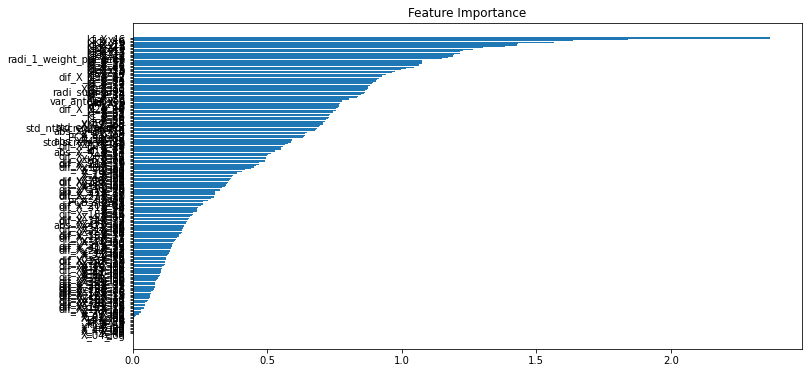

In [ ]:

feature_importance = final_models[0][2].feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(submit_x.columns)[sorted_idx])
plt.title('Feature Importance')

print(np.array(submit_x.columns)[sorted_idx])

# Lab

In [ ]:
model_idx=np.array(sorted(scores.items(), key = lambda item : item[1]))[:5, 0]
best_ml_1=[value for i, value in enumerate(base_ml) if i in model_idx]
best_ml_1

In [ ]:
best_ml_14

In [ ]:
meta_clf=LinearRegression()
meta_clf.fit(meta_ml_X_train, y_train)
prediction=meta_clf.predict(meta_ml_X_test)

## Valid

nrmse_all=sep_lg_nrmse(y_test, prediction)
print("nmae_all: ", nrmse_all)


In [ ]:
print(best_ml_01)
print(best_ml_02)
print(best_ml_03)
print(best_ml_04)
print(best_ml_05)
print(best_ml_06)
print(best_ml_07)
print(best_ml_08)
print(best_ml_09)
print(best_ml_10)
print(best_ml_11)
print(best_ml_12)
print(best_ml_13)
print(best_ml_14)


NameError: name 'best_ml_01' is not defined

In [ ]:
meta_ml_X_test

In [ ]:
res = []
for k in val_list:
    X_train, X_test, y_train, y_test = train_test_split(train_x, train_y['Y_'+str(k)], test_size = 0.2, random_state=1422)
    meta_ml_X_train=[]
    meta_ml_X_test=[]
    for estimator in tqdm(globals()['best_ml_%s' %k]):
        temp_X_train, temp_X_test = get_stacking_ml_datasets(estimator, X_train, y_train, X_test, 5)
        meta_ml_X_train.append(temp_X_train)
        meta_ml_X_test.append(temp_X_test)

    meta_ml_X_train=np.hstack(meta_ml_X_train)
    meta_ml_X_test=np.hstack(meta_ml_X_test)

    print(meta_ml_X_train.shape, meta_ml_X_test.shape)

    globals()['meta_clf_%s' %k] = LinearRegression()
    globals()['meta_clf_%s' %k].fit(meta_ml_X_train, y_train)
    prediction=globals()['meta_clf_%s' %k].predict(meta_ml_X_test)
    res.append(prediction)

    nrmse_best= sep_lg_nrmse(y_test, prediction)
    print("nrmse_best: ", nrmse_best)



In [ ]:
y_test

In [ ]:
pd.DataFrame(res)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size = 0.2, random_state=1422)


In [ ]:
pd.DataFrame(res).transpose()

In [ ]:
lg_nrmse(y_test,pd.DataFrame(res).transpose())

In [ ]:
def predict_model(k,submit, model, test_x):
    res = model.predict(test_x)
    submit['Y_'+k] = res
    return submit

In [ ]:
pd.read_csv(base+'sample_submission.csv')

,ID,Y_01,Y_02,Y_03,Y_04,Y_05,Y_06,Y_07,Y_08,Y_09,Y_10,Y_11,Y_12,Y_13,Y_14
0,TEST_00001,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,TEST_00002,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,TEST_00003,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,TEST_00004,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,TEST_00005,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39603,TEST_39604,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39604,TEST_39605,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39605,TEST_39606,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39606,TEST_39607,0,0,0,0,0,0,0,0,0,0,0,0,0,0


100%|██████████| 54/54 [00:39<00:00,  1.38it/s]
C:\Users\rkd20\AppData\Local\Temp/ipykernel_30064/4256007863.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  submit_x[col+"_log"] = submit_x[col].apply(lambda x : math.log(x))
C:\Users\rkd20\AppData\Local\Temp/ipykernel_30064/4256007863.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  submit_x['dif_'+a+b] = submit_x[a]-submit_x[b]
C:\Users\rkd20\AppData\Local\Temp/ipykernel_30064/4256007863.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the r

In [ ]:
def get_stacking_preidct(model, X_train_n, y_train_n,y_test_n X_test_n, submit_x ,n_folds):
    
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    submit_pred = np.zeros((submit_x.shape[0], n_folds))
    best_model = model
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n, y_train_n)):
        X_tr = X_train_n.iloc[train_index]
        y_tr = y_train_n.iloc[train_index]
        X_te = X_train_n.iloc[valid_index]
        
        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        test_pred[:, folder_counter] = model.predict(X_test_n)
        submit_pred[:, folder_counter] = model.predict(submit_x)
        
        nrmse_best= sep_lg_nrmse(y_test, val_prediction)
        
#     test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1) 
#     submit_pred_mean = np.mean(submit_pred, axis=1).reshape(-1,1)    
    
    
    return train_fold_pred, test_pred, submit_pred,best_model

In [ ]:
val_res = []
submit_res = []
all_meta_ml_X_train = []
all_meta_ml_X_test=[]
all_meta_ml_X_submit =[]
for k in val_list:
    X_train, X_test, y_train, y_test = train_test_split(train_x, train_y['Y_'+str(k)], test_size = 0.2, random_state=1422)
    meta_ml_X_train=[]
    meta_ml_X_test=[]
    meta_ml_X_submit = []
    for estimator in tqdm(globals()['best_ml_%s' %k]):
        temp_X_train, temp_X_test, temp_X_submit = get_stacking_preidct(estimator, X_train, y_train,y_test, X_test, submit_x, 5)
        meta_ml_X_train.append(temp_X_train)
        meta_ml_X_test.append(temp_X_test)
        meta_ml_X_submit.append(temp_X_submit)

    meta_ml_X_train=np.hstack(meta_ml_X_train)
    meta_ml_X_test=np.hstack(meta_ml_X_test)
    meta_ml_X_submit = np.hstack(meta_ml_X_submit)
    all_meta_ml_X_train.append(meta_ml_X_train)
    all_meta_ml_X_test.append(meta_ml_X_test)
    all_meta_ml_X_submit.append(meta_ml_X_submit)

#     print(meta_ml_X_train.shape, meta_ml_X_test.shape, meta_ml_X_submit.shape)

#     globals()['meta_clf_%s' %k] = LinearRegression()
#     globals()['meta_clf_%s' %k].fit(meta_ml_X_train, y_train)
#     val_prediction=globals()['meta_clf_%s' %k].predict(meta_ml_X_test)
#     res_prediction = globals()['meta_clf_%s' %k].predict(meta_ml_X_submit)
#     val_res.append(val_prediction)
#     submit_res.append(res_prediction)
#     ## Valid

#     nrmse_best= sep_lg_nrmse(y_test, val_prediction)
#     print("nrmse_best: ", nrmse_best)
#     submit_df['Y_'+k] = res_prediction


In [ ]:
all_meta_ml_X_train[1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size = 0.2, random_state=1422)

In [ ]:
lg_nrmse(y_test,pd.DataFrame(val_res).transpose())

In [ ]:
submit_df.to_csv("top3_5fold.csv", index=False)

In [ ]:
submit_res[0].shape